# Project: Prediction Number of Taxi Orders 

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we predicted the amount of taxi orders for the next hour by building a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions/Specifications

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.



## Libraries Used for Anlysis

In [1]:
import pandas as pd 
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor 
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor as xgb

%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column and the index represents the datetime data, every 10 minutes. 

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates = ['datetime'], index_col= ['datetime'])
data.head()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

## Preparation and Analysis
There were no missing values in the column `num_orders`

In [3]:
#checking for Null values
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


The datetime values in the index are in chronological order. 

In [4]:
#checking if datetime index is monotonic
data = data.sort_index()
data.index.is_monotonic

True

In [5]:
data.head(10)

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
2018-03-01 00:50:00          21
2018-03-01 01:00:00           7
2018-03-01 01:10:00           5
2018-03-01 01:20:00          17
2018-03-01 01:30:00          12

In [6]:
#resampling the datatime interval from 10 mins to 1 hour
data = data.resample('1H').sum()

In [7]:
data.head()

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

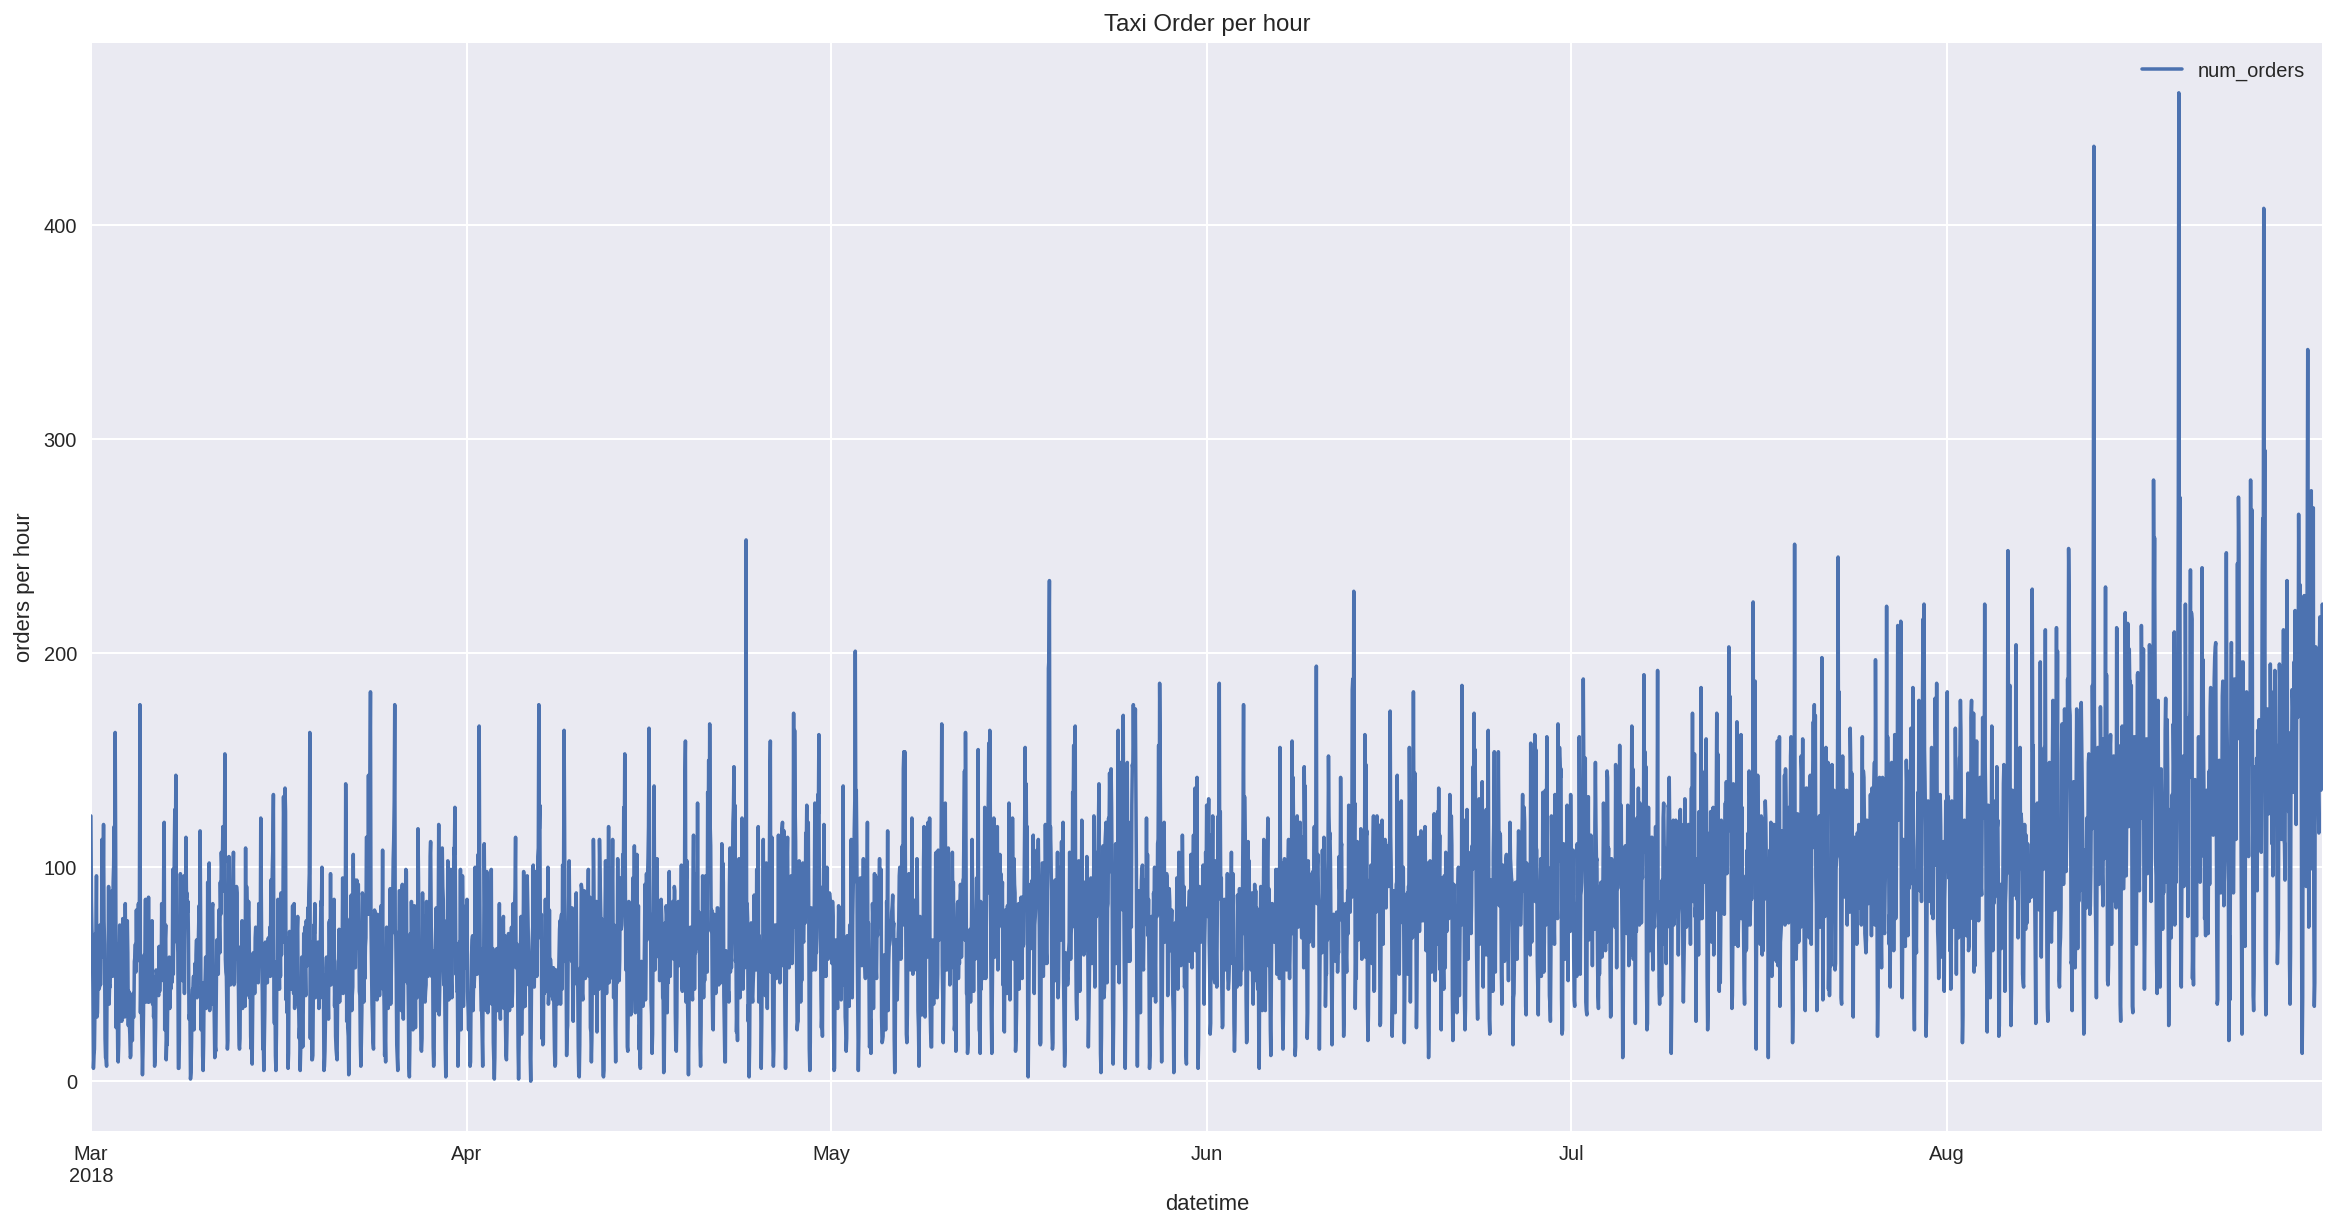

In [8]:
#plotting the num_orders data resampled per hour. 
data.plot(figsize = (20,10))
plt.title('Taxi Order per hour')
plt.ylabel('orders per hour')
plt.show()

In this section, we compared the graphs of rolling mean between values of window size of 6,12,24, and 36 hours to see observe how the distributions compared and how smother the graph gets as the value of hours increases. We noticed that the value of 24 hours results in a smoother rolling. 

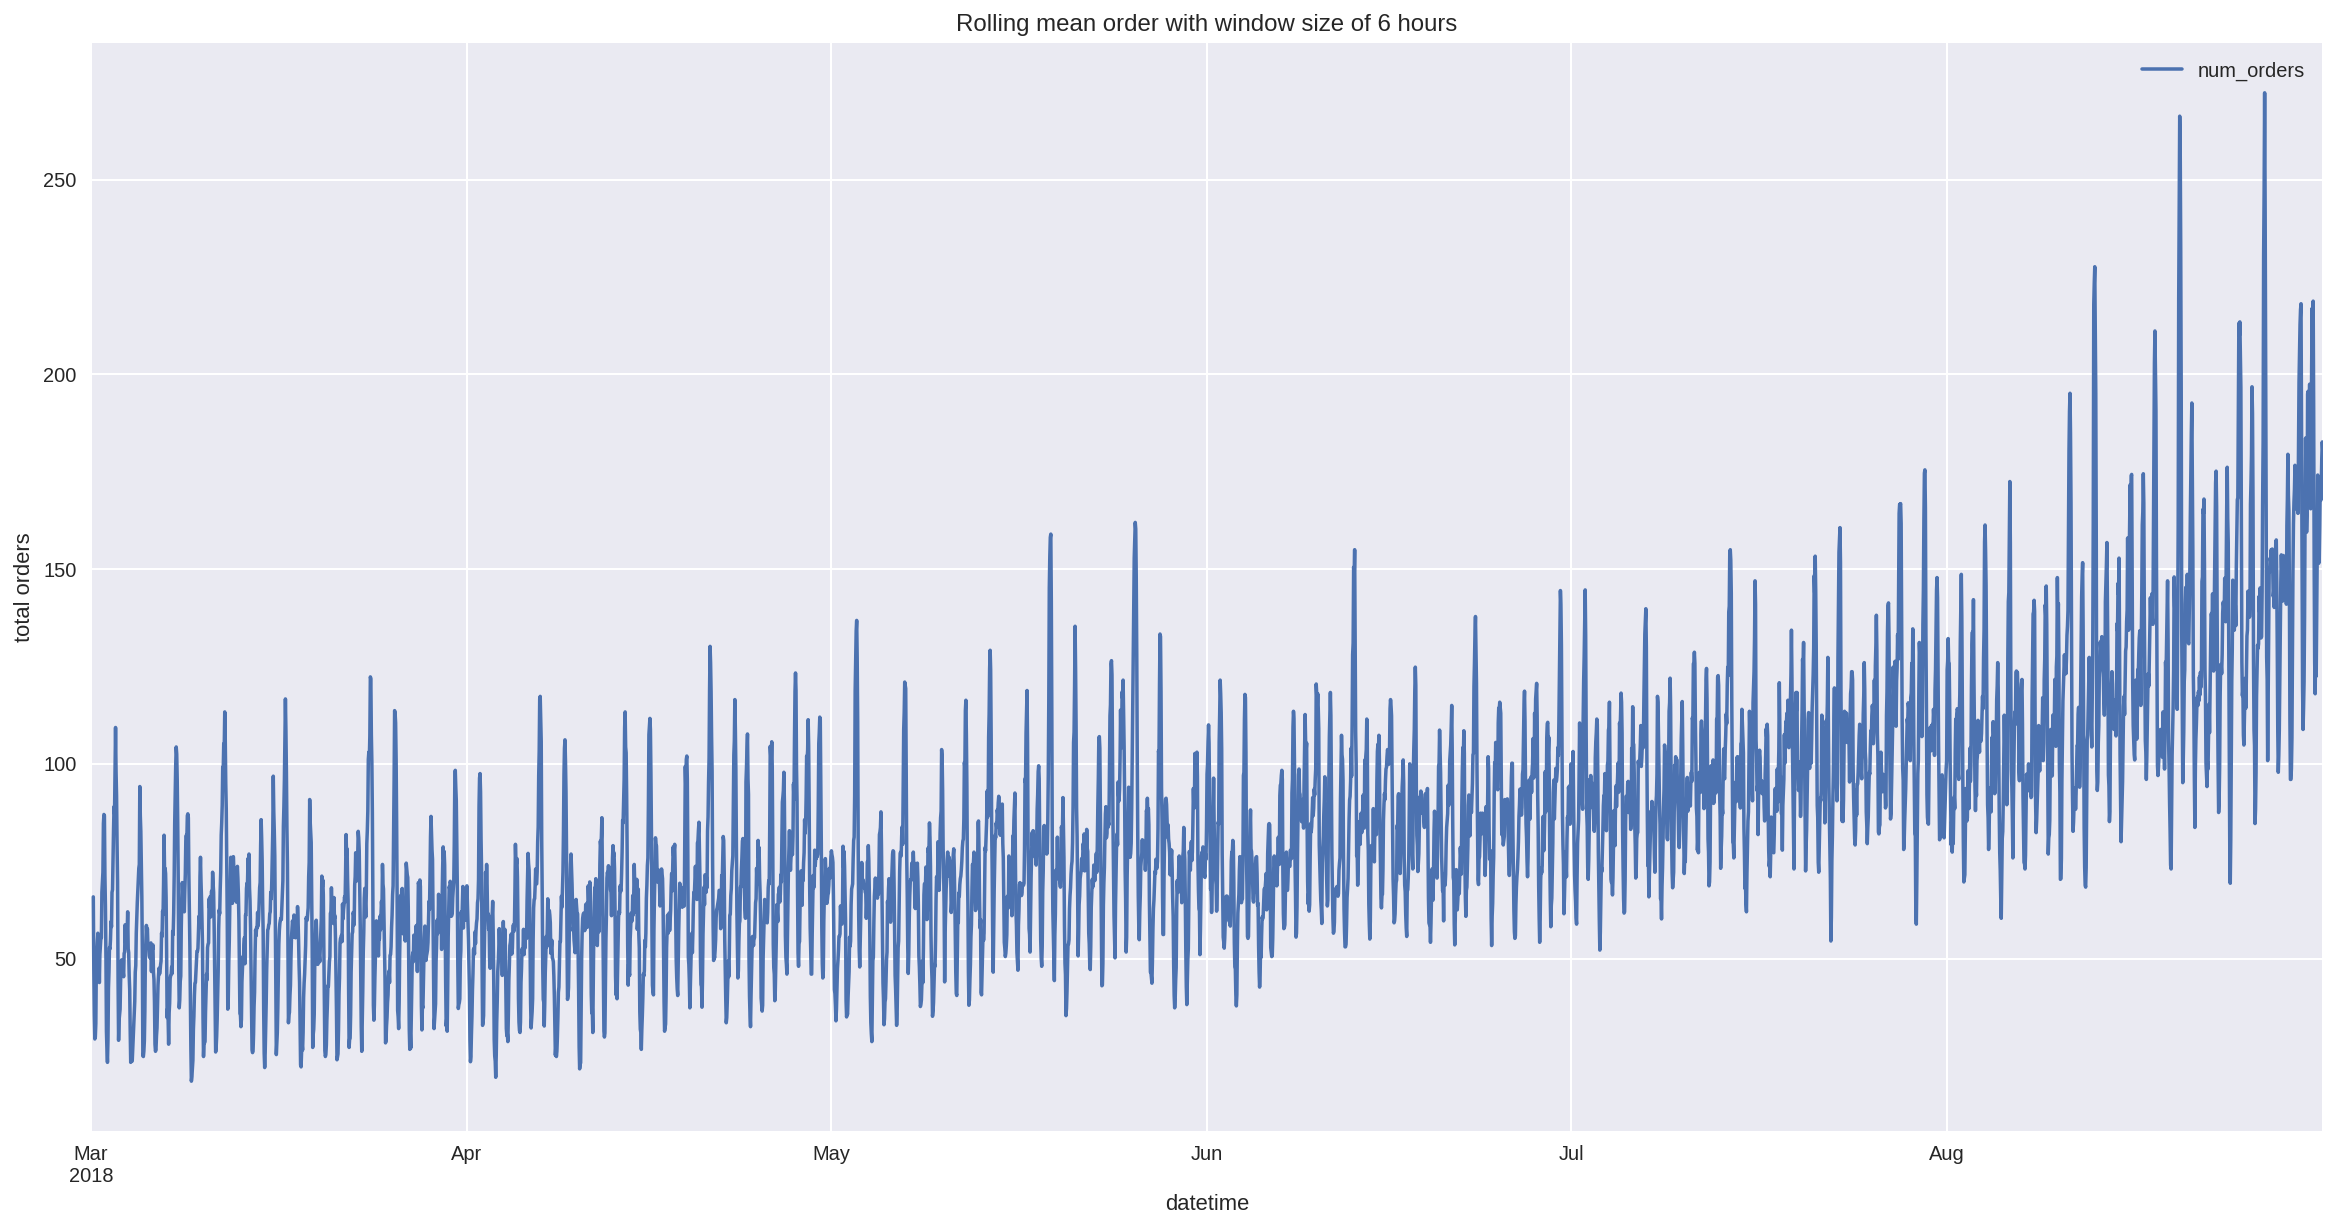

In [9]:
data.rolling(6).mean().plot(figsize=(20,10))
plt.title('Rolling mean order with window size of 6 hours')
plt.ylabel('total orders')
plt.show()

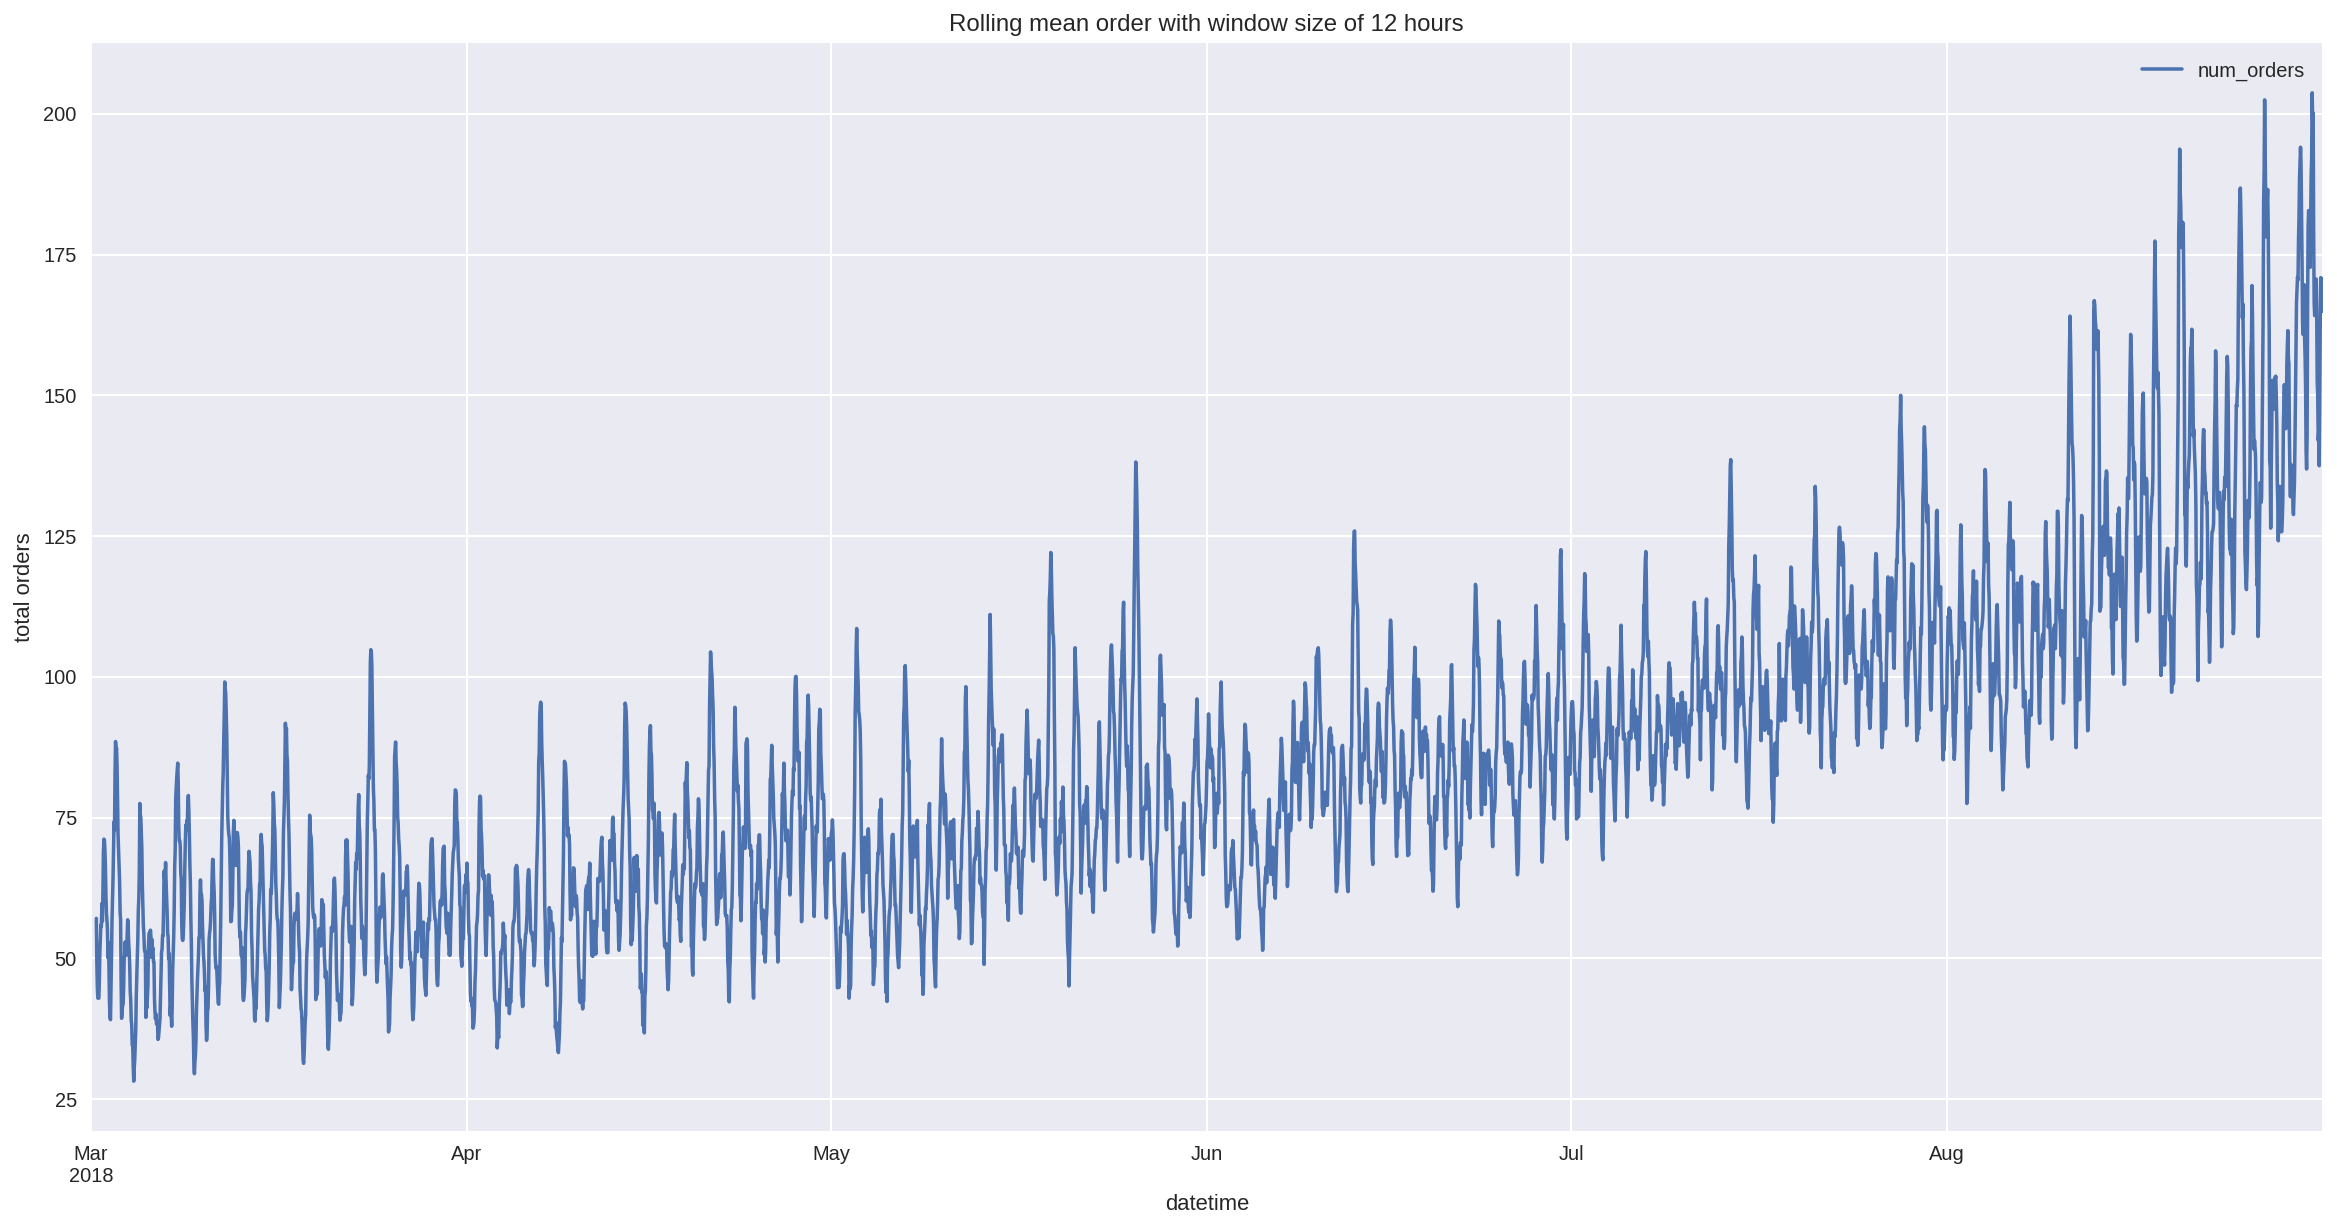

In [10]:
data.rolling(12).mean().plot(figsize=(20,10))
plt.title('Rolling mean order with window size of 12 hours')
plt.ylabel('total orders')
plt.show()

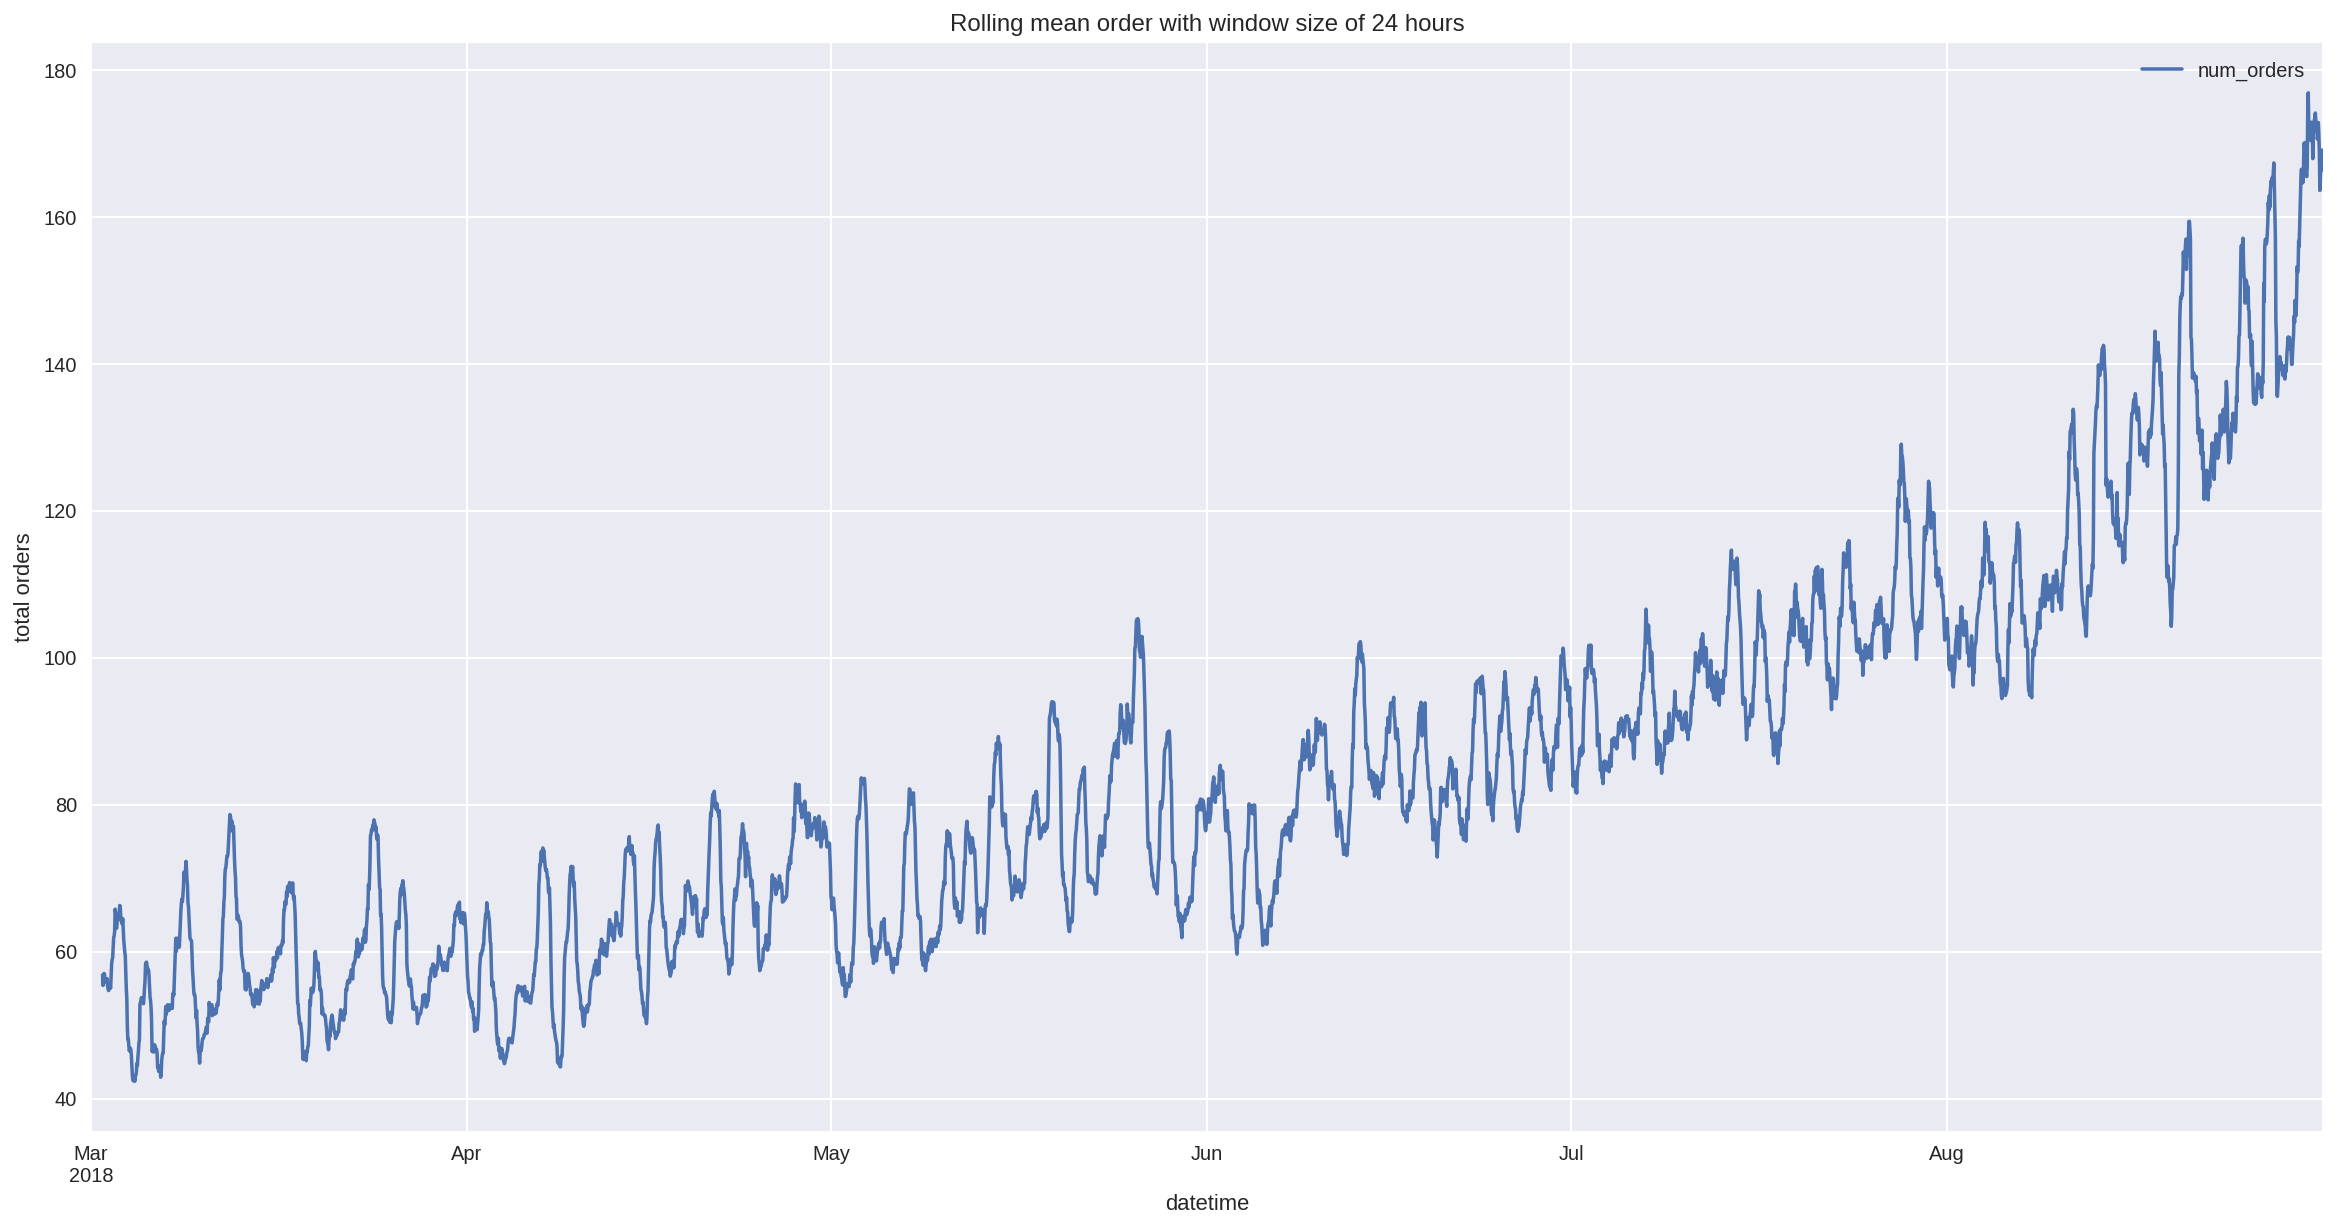

In [11]:
data.rolling(24).mean().plot(figsize=(20,10))
plt.title('Rolling mean order with window size of 24 hours')
plt.ylabel('total orders')
plt.show()

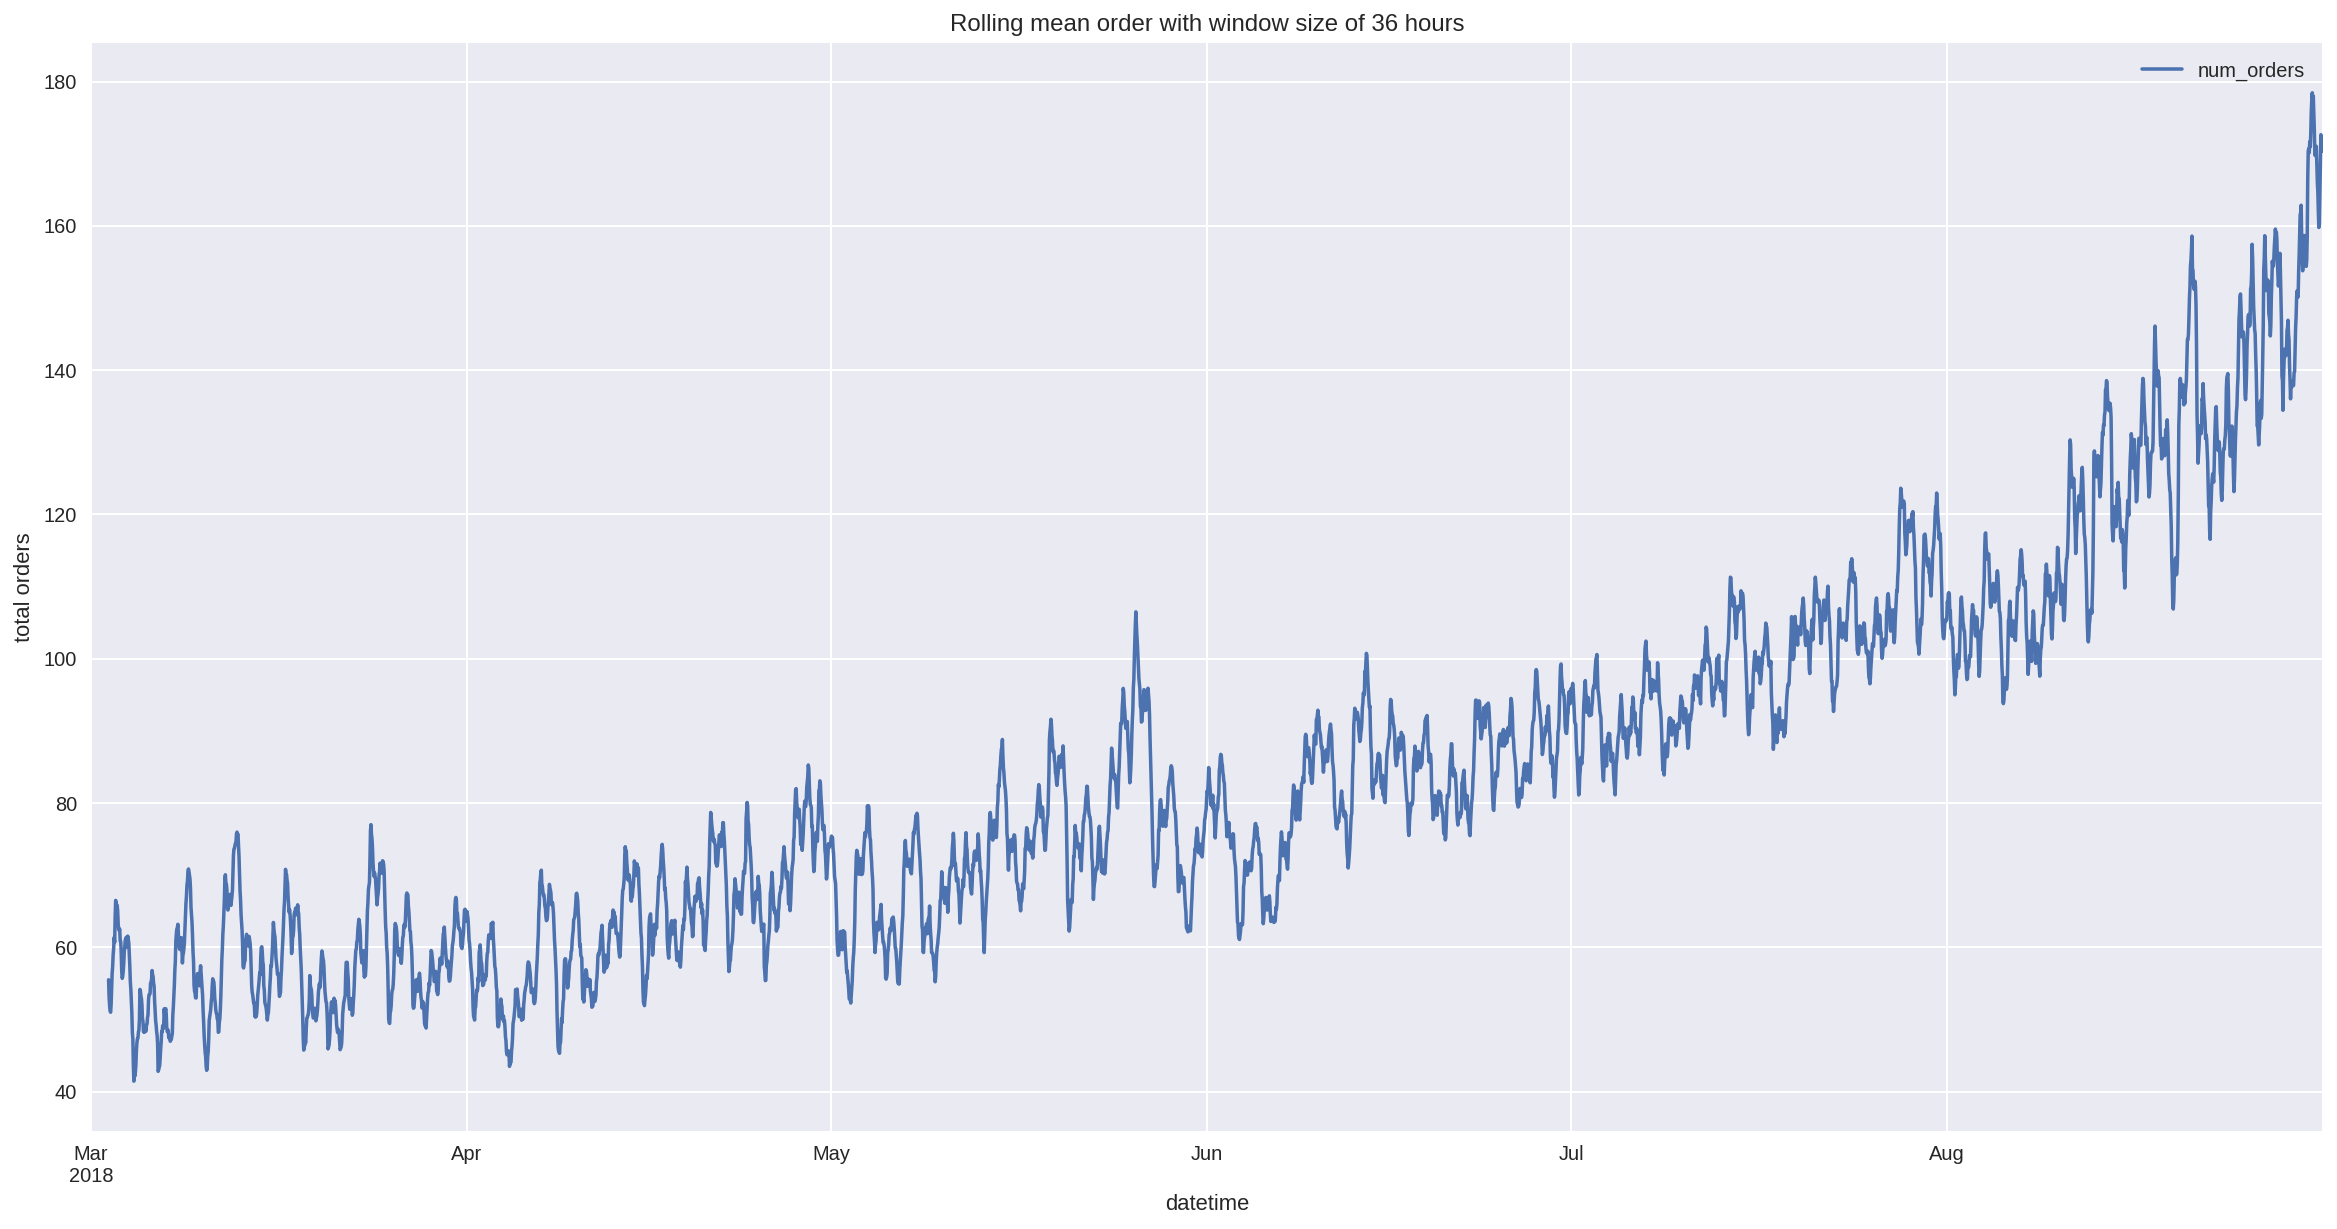

In [12]:
data.rolling(36).mean().plot(figsize=(20,10))
plt.title('Rolling mean order with window size of 36 hours')
plt.ylabel('total orders')
plt.show()

In this section, we analyzed the trend and seasonality of the `num_orders` values, resampled per day, over time. We observed that the trend grows postitively, with a max value of 1278.9 and maximum value of 3703.7 order numbers, between March 1st and August 31st, 2018. 

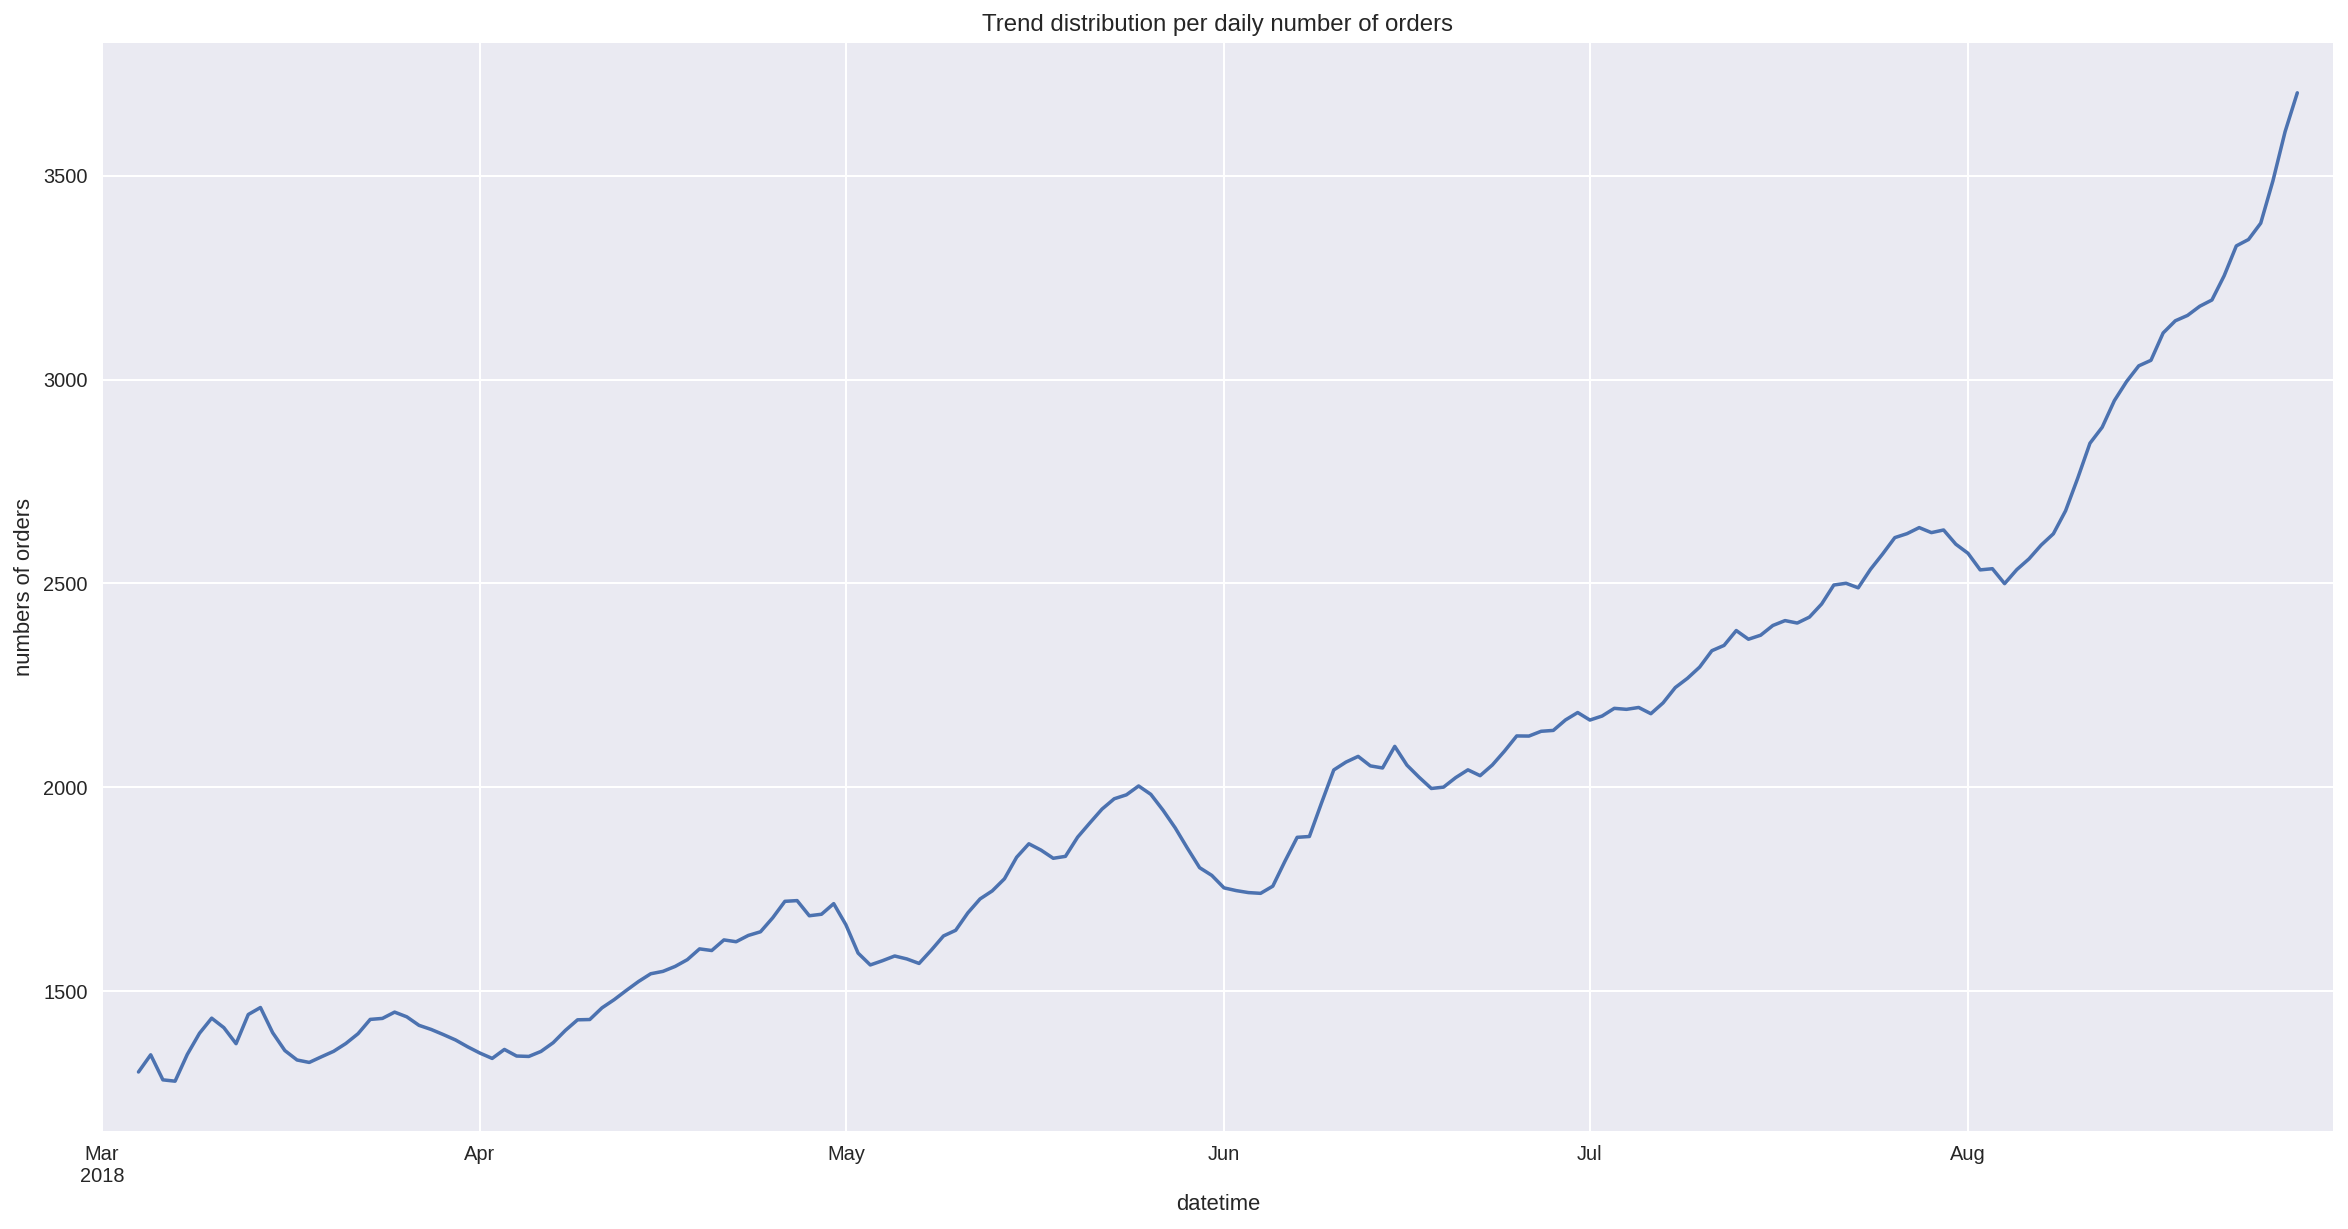

In [13]:
decomposed = seasonal_decompose(data.resample('1D').sum())
decomposed.trend.plot(figsize=(20,10))
plt.title('Trend distribution per daily number of orders')
plt.ylabel('numbers of orders')
plt.show()

In [14]:
print('min', decomposed.trend.min())
print('max', decomposed.trend.max())

min 1278.857142857143
max 3703.714285714286


The seasonality for the months between march 2018 and april 2018 had maximum values of orders on Mondays, with maximum values of 149.04 number of orders. The same pattern in seasonality repeated for the other months between may 2018 through august 2018. The amplitude for the seasonality swings are about 331.5 orders. 

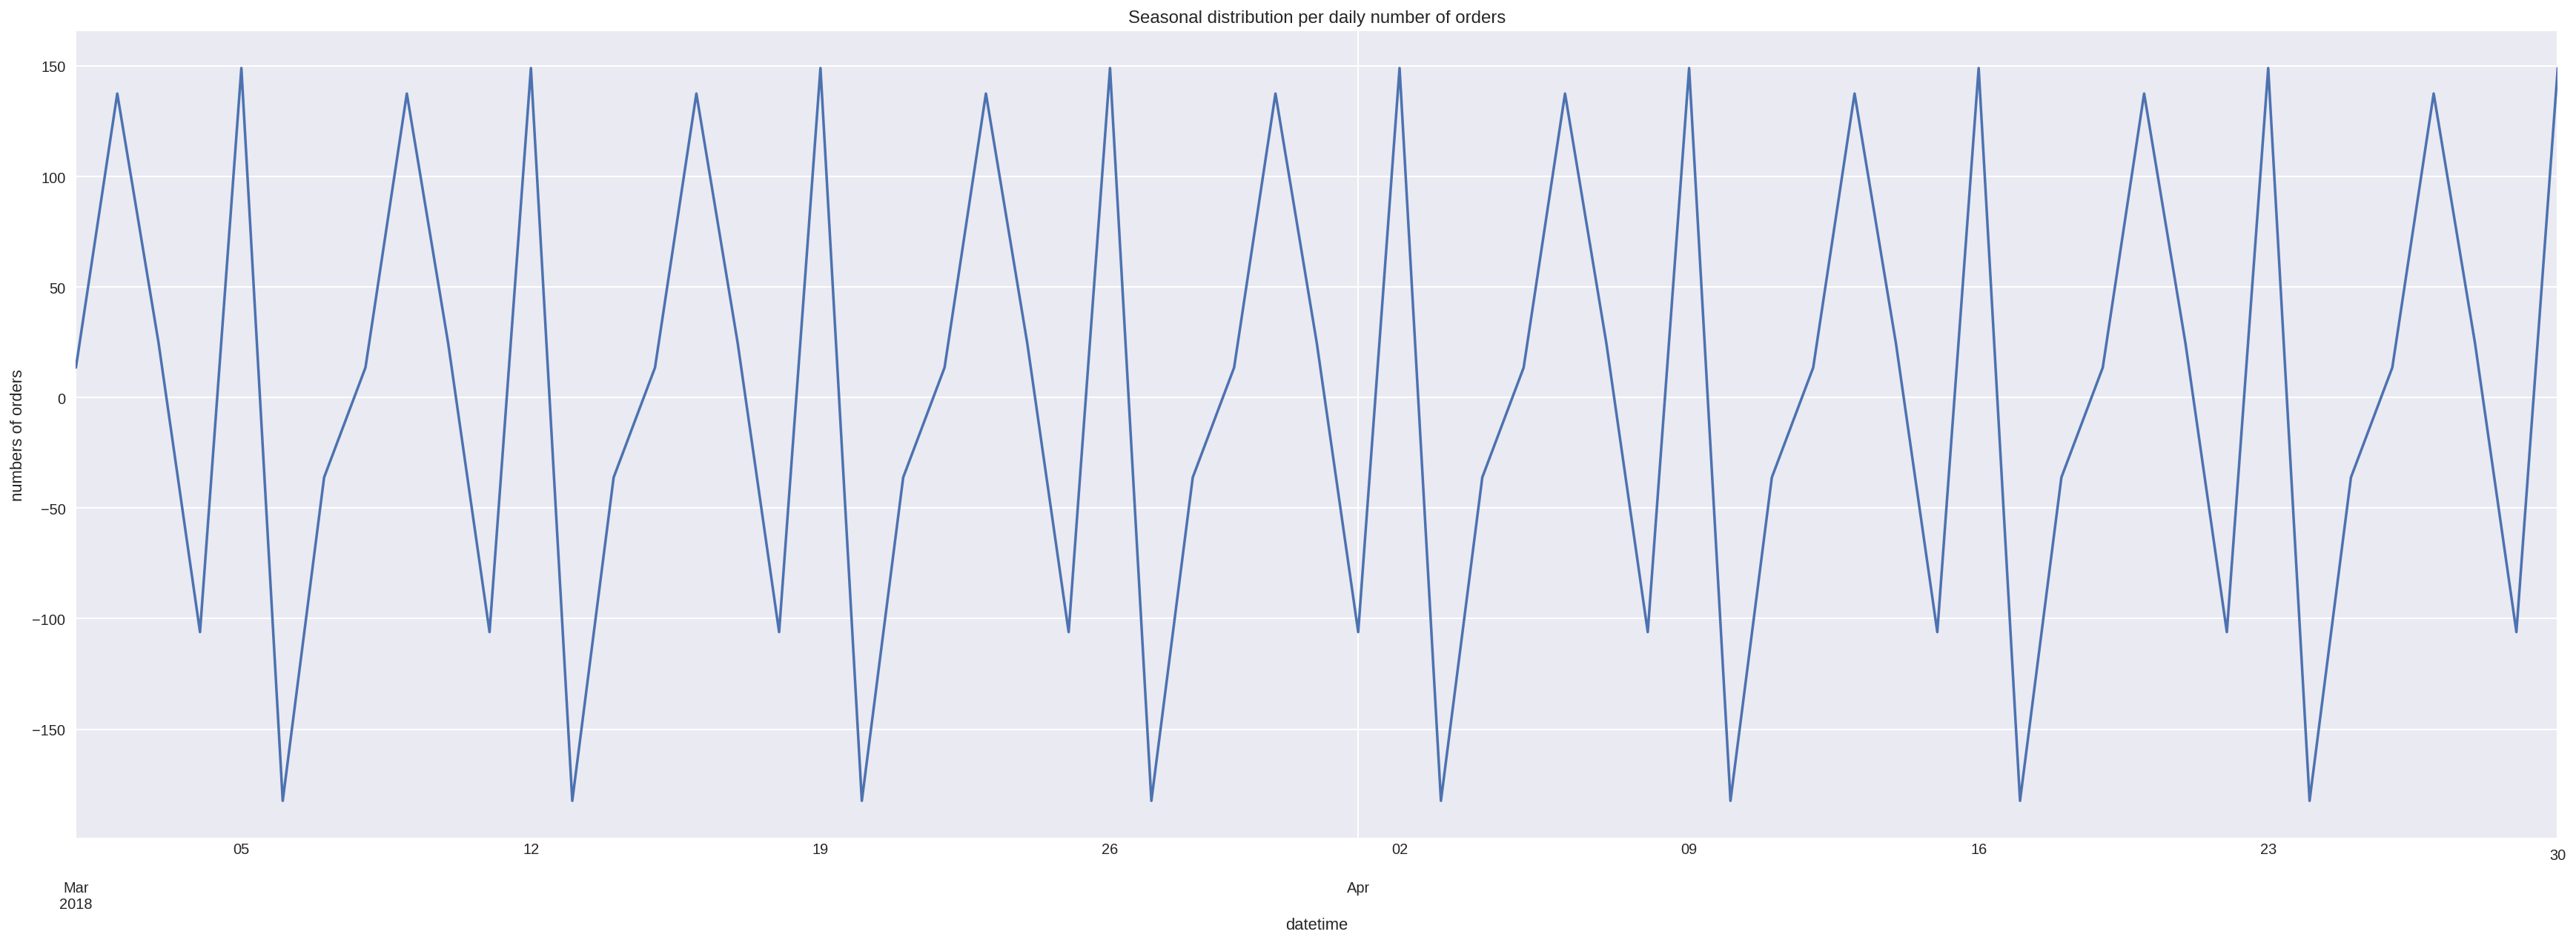

In [15]:
decomposed.seasonal['2018-03':'2018-04'].plot(figsize=(30,10))
plt.title('Seasonal distribution per daily number of orders')
plt.ylabel('numbers of orders')
plt.show()

In [16]:
print('min', decomposed.seasonal['2018-03':'2018-04'].min())
max_march_april = decomposed.seasonal['2018-03':'2018-04'].max()
print('max', max_march_april)

decomposed.seasonal['2018-03':'2018-04'].head(26)

min -182.41070643642075
max 149.04533751962322


datetime
2018-03-01     13.568634
2018-03-02    137.511491
2018-03-03     24.505777
2018-03-04   -106.092025
2018-03-05    149.045338
2018-03-06   -182.410706
2018-03-07    -36.128509
2018-03-08     13.568634
2018-03-09    137.511491
2018-03-10     24.505777
2018-03-11   -106.092025
2018-03-12    149.045338
2018-03-13   -182.410706
2018-03-14    -36.128509
2018-03-15     13.568634
2018-03-16    137.511491
2018-03-17     24.505777
2018-03-18   -106.092025
2018-03-19    149.045338
2018-03-20   -182.410706
2018-03-21    -36.128509
2018-03-22     13.568634
2018-03-23    137.511491
2018-03-24     24.505777
2018-03-25   -106.092025
2018-03-26    149.045338
Freq: D, Name: seasonal, dtype: float64

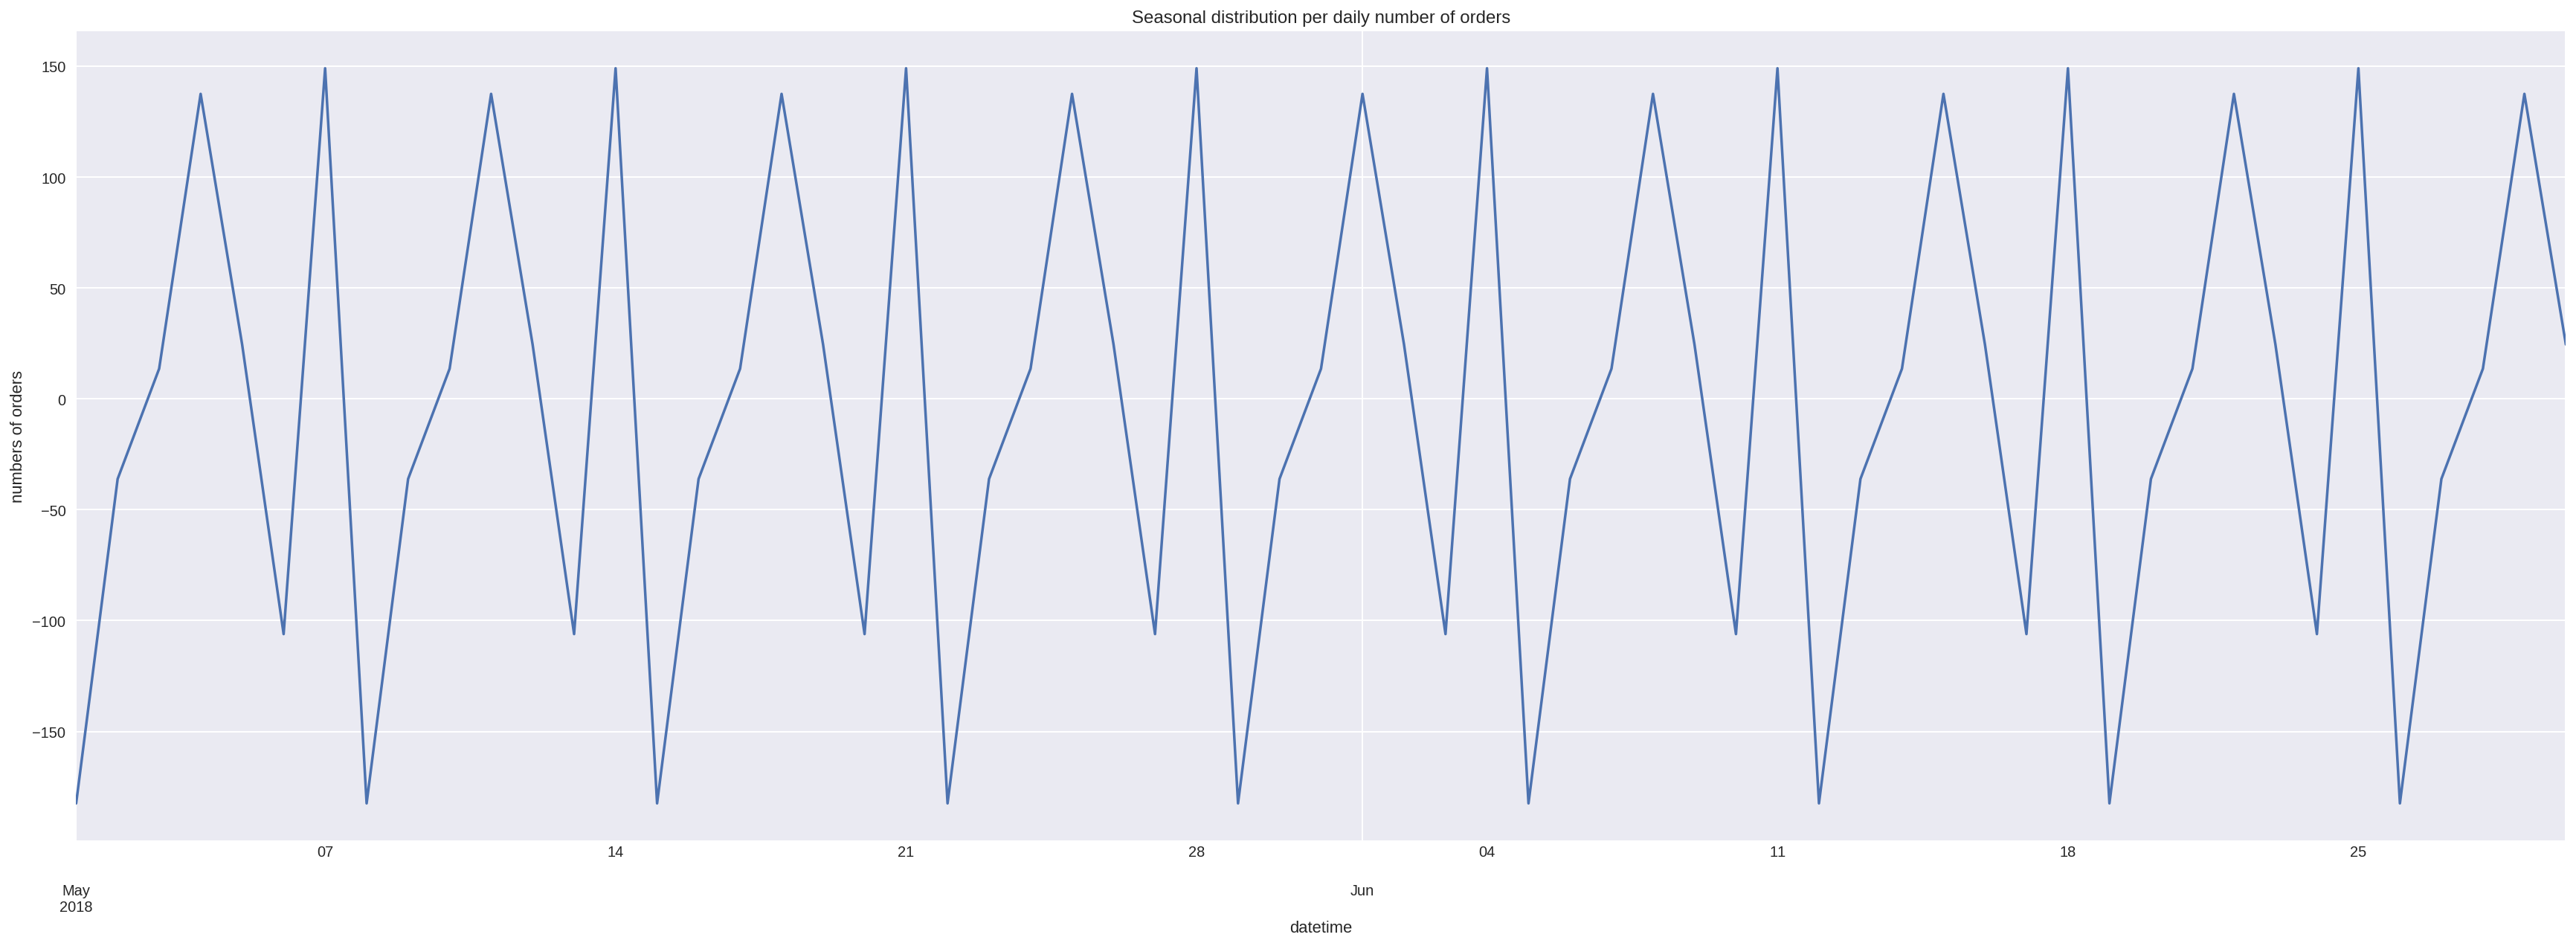

In [17]:
decomposed.seasonal['2018-05':'2018-06'].plot(figsize=(30,10))
plt.title('Seasonal distribution per daily number of orders')
plt.ylabel('numbers of orders')
plt.show()

In [18]:
print('min', decomposed.seasonal['2018-05':'2018-06'].min())
may_june_max = decomposed.seasonal['2018-05':'2018-06'].max()
print('max', may_june_max)

decomposed.seasonal['2018-04':'2018-06'].head(26)

min -182.41070643642075
max 149.04533751962322


datetime
2018-04-01   -106.092025
2018-04-02    149.045338
2018-04-03   -182.410706
2018-04-04    -36.128509
2018-04-05     13.568634
2018-04-06    137.511491
2018-04-07     24.505777
2018-04-08   -106.092025
2018-04-09    149.045338
2018-04-10   -182.410706
2018-04-11    -36.128509
2018-04-12     13.568634
2018-04-13    137.511491
2018-04-14     24.505777
2018-04-15   -106.092025
2018-04-16    149.045338
2018-04-17   -182.410706
2018-04-18    -36.128509
2018-04-19     13.568634
2018-04-20    137.511491
2018-04-21     24.505777
2018-04-22   -106.092025
2018-04-23    149.045338
2018-04-24   -182.410706
2018-04-25    -36.128509
2018-04-26     13.568634
Freq: D, Name: seasonal, dtype: float64

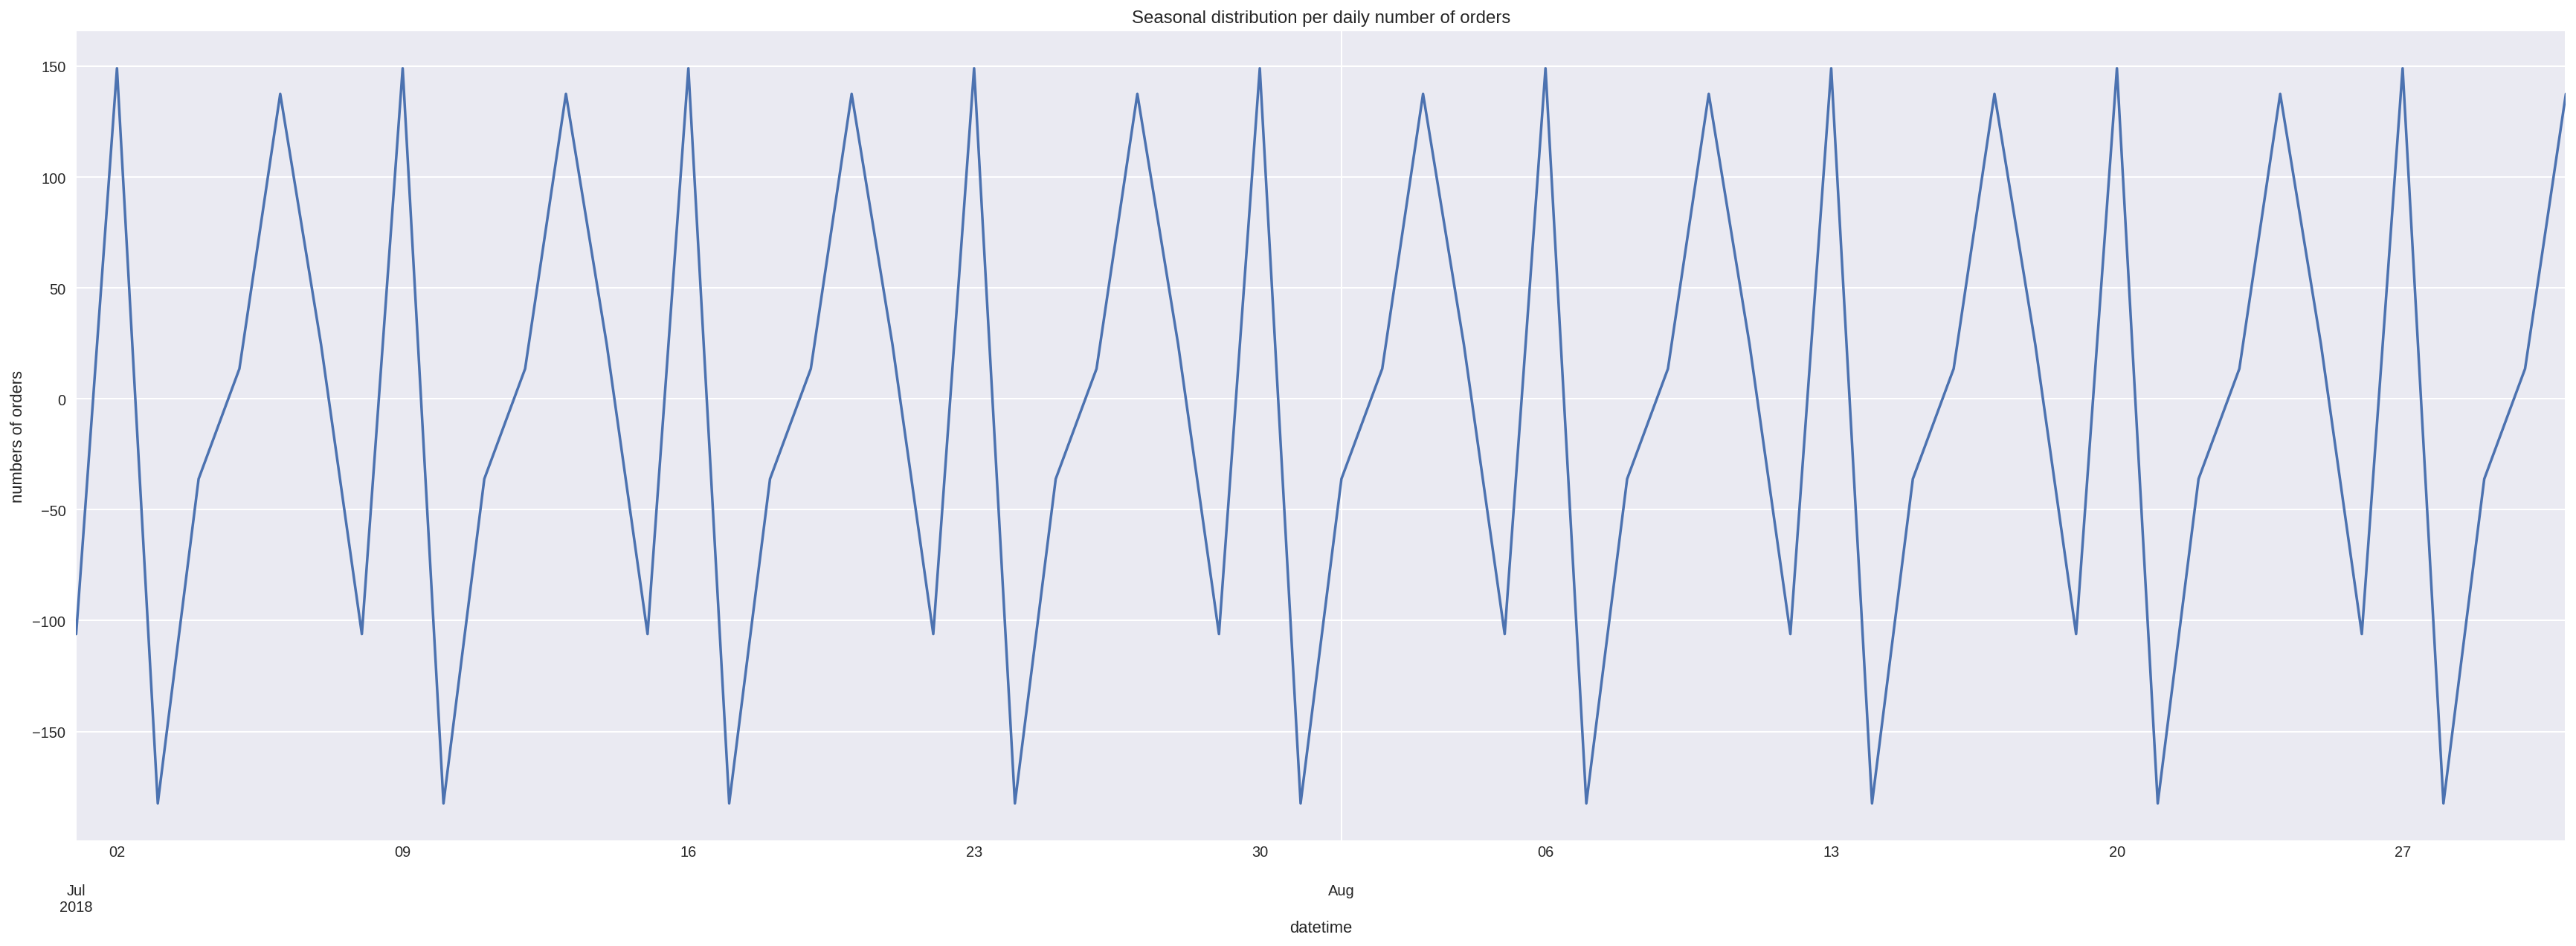

In [19]:
decomposed.seasonal['2018-07':'2018-08'].plot(figsize=(30,10))
plt.title('Seasonal distribution per daily number of orders')
plt.ylabel('numbers of orders')
plt.show()

In [20]:
print('min', decomposed.seasonal['2018-07':'2018-08'].min())
july_aug_max = decomposed.seasonal['2018-07':'2018-08'].max()
print('max', july_aug_max)

decomposed.seasonal['2018-07':'2018-08'].head(26)

min -182.41070643642075
max 149.04533751962322


datetime
2018-07-01   -106.092025
2018-07-02    149.045338
2018-07-03   -182.410706
2018-07-04    -36.128509
2018-07-05     13.568634
2018-07-06    137.511491
2018-07-07     24.505777
2018-07-08   -106.092025
2018-07-09    149.045338
2018-07-10   -182.410706
2018-07-11    -36.128509
2018-07-12     13.568634
2018-07-13    137.511491
2018-07-14     24.505777
2018-07-15   -106.092025
2018-07-16    149.045338
2018-07-17   -182.410706
2018-07-18    -36.128509
2018-07-19     13.568634
2018-07-20    137.511491
2018-07-21     24.505777
2018-07-22   -106.092025
2018-07-23    149.045338
2018-07-24   -182.410706
2018-07-25    -36.128509
2018-07-26     13.568634
Freq: D, Name: seasonal, dtype: float64

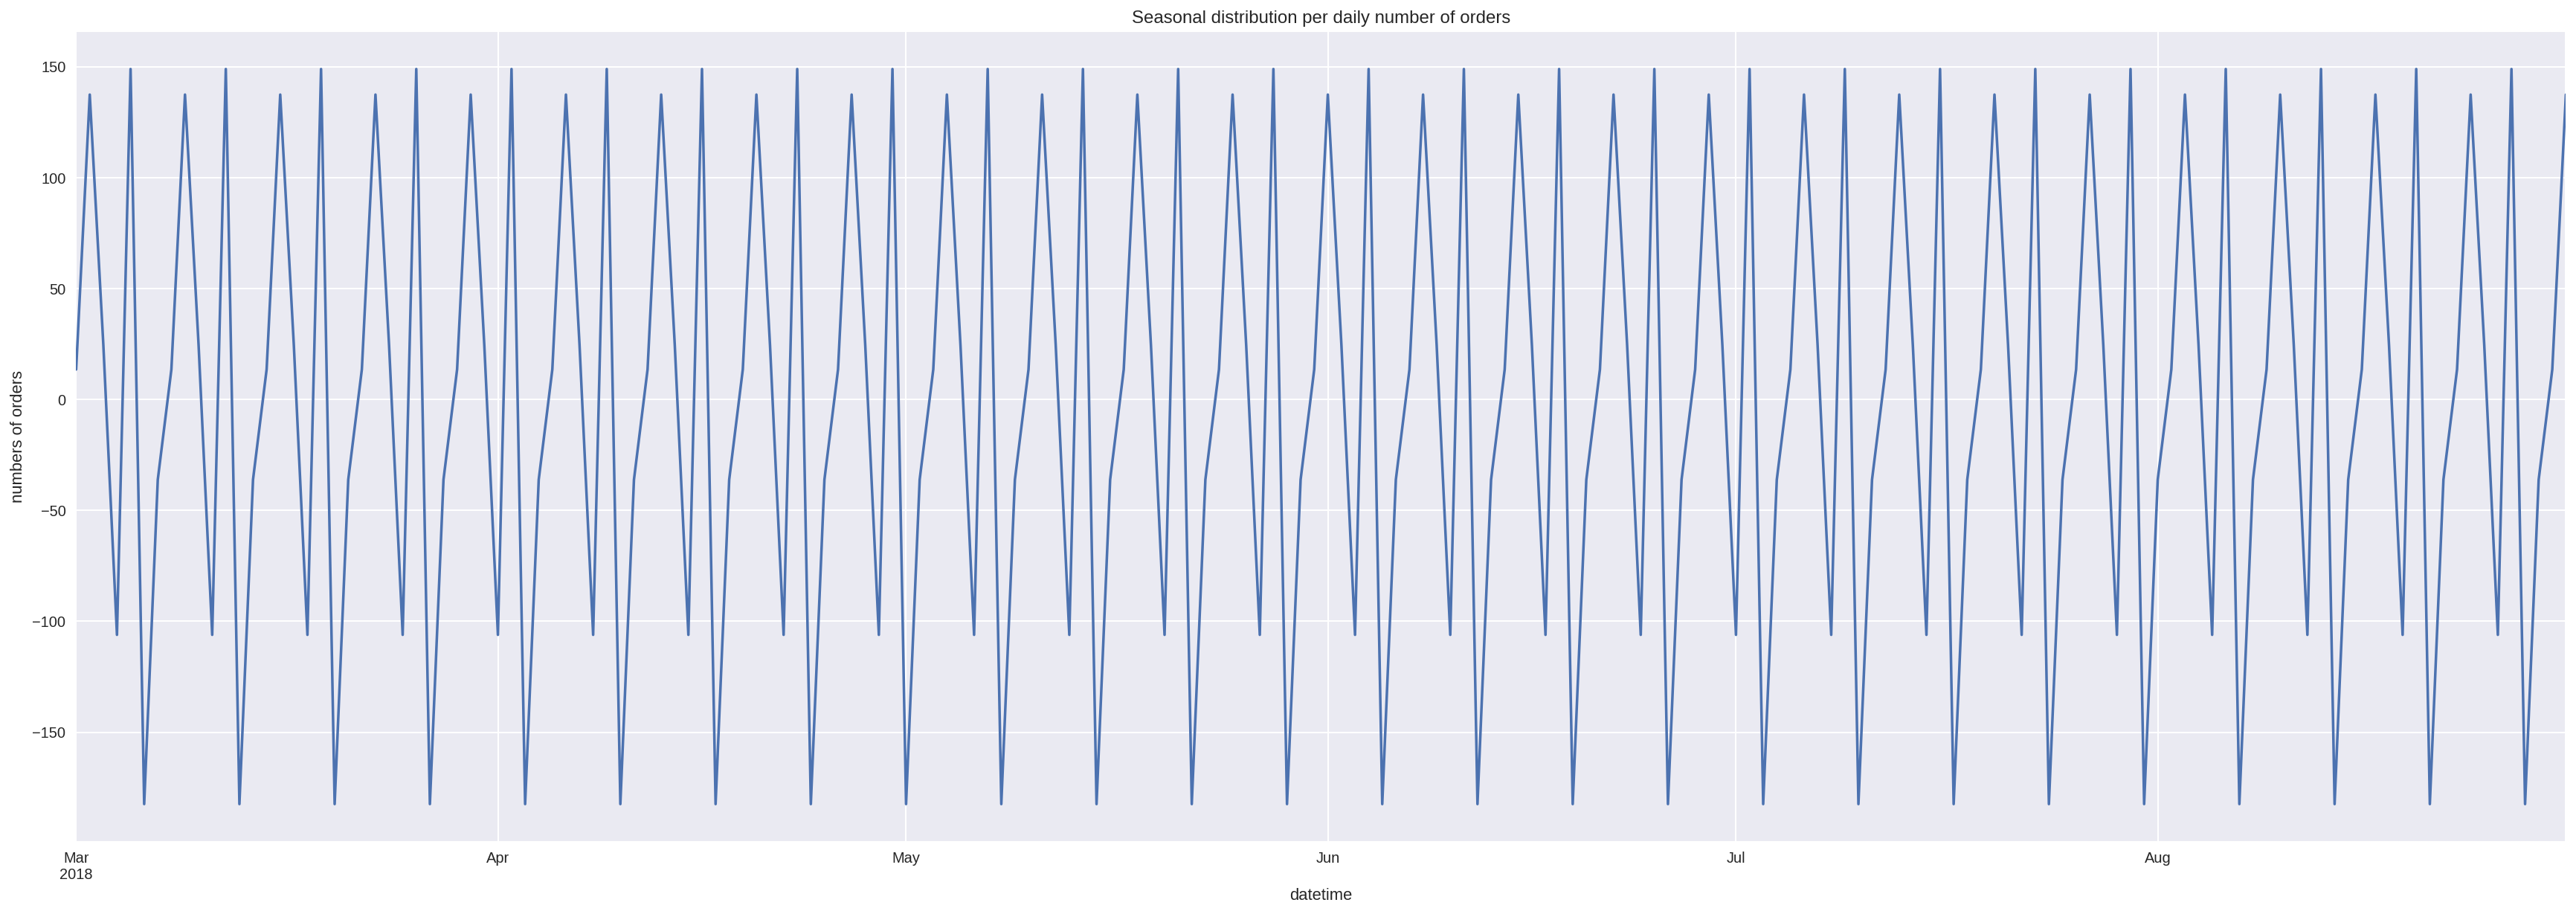

In [21]:
#summary of seasonality of number of order between March 2018 and August 2018. 
decomposed.seasonal.plot(figsize=(30,10))
plt.title('Seasonal distribution per daily number of orders')
plt.ylabel('numbers of orders')
plt.show()

From this section, we observed that the seasonality of orders per hour peaks at around midnight with maximum values of 60.2 orders. 

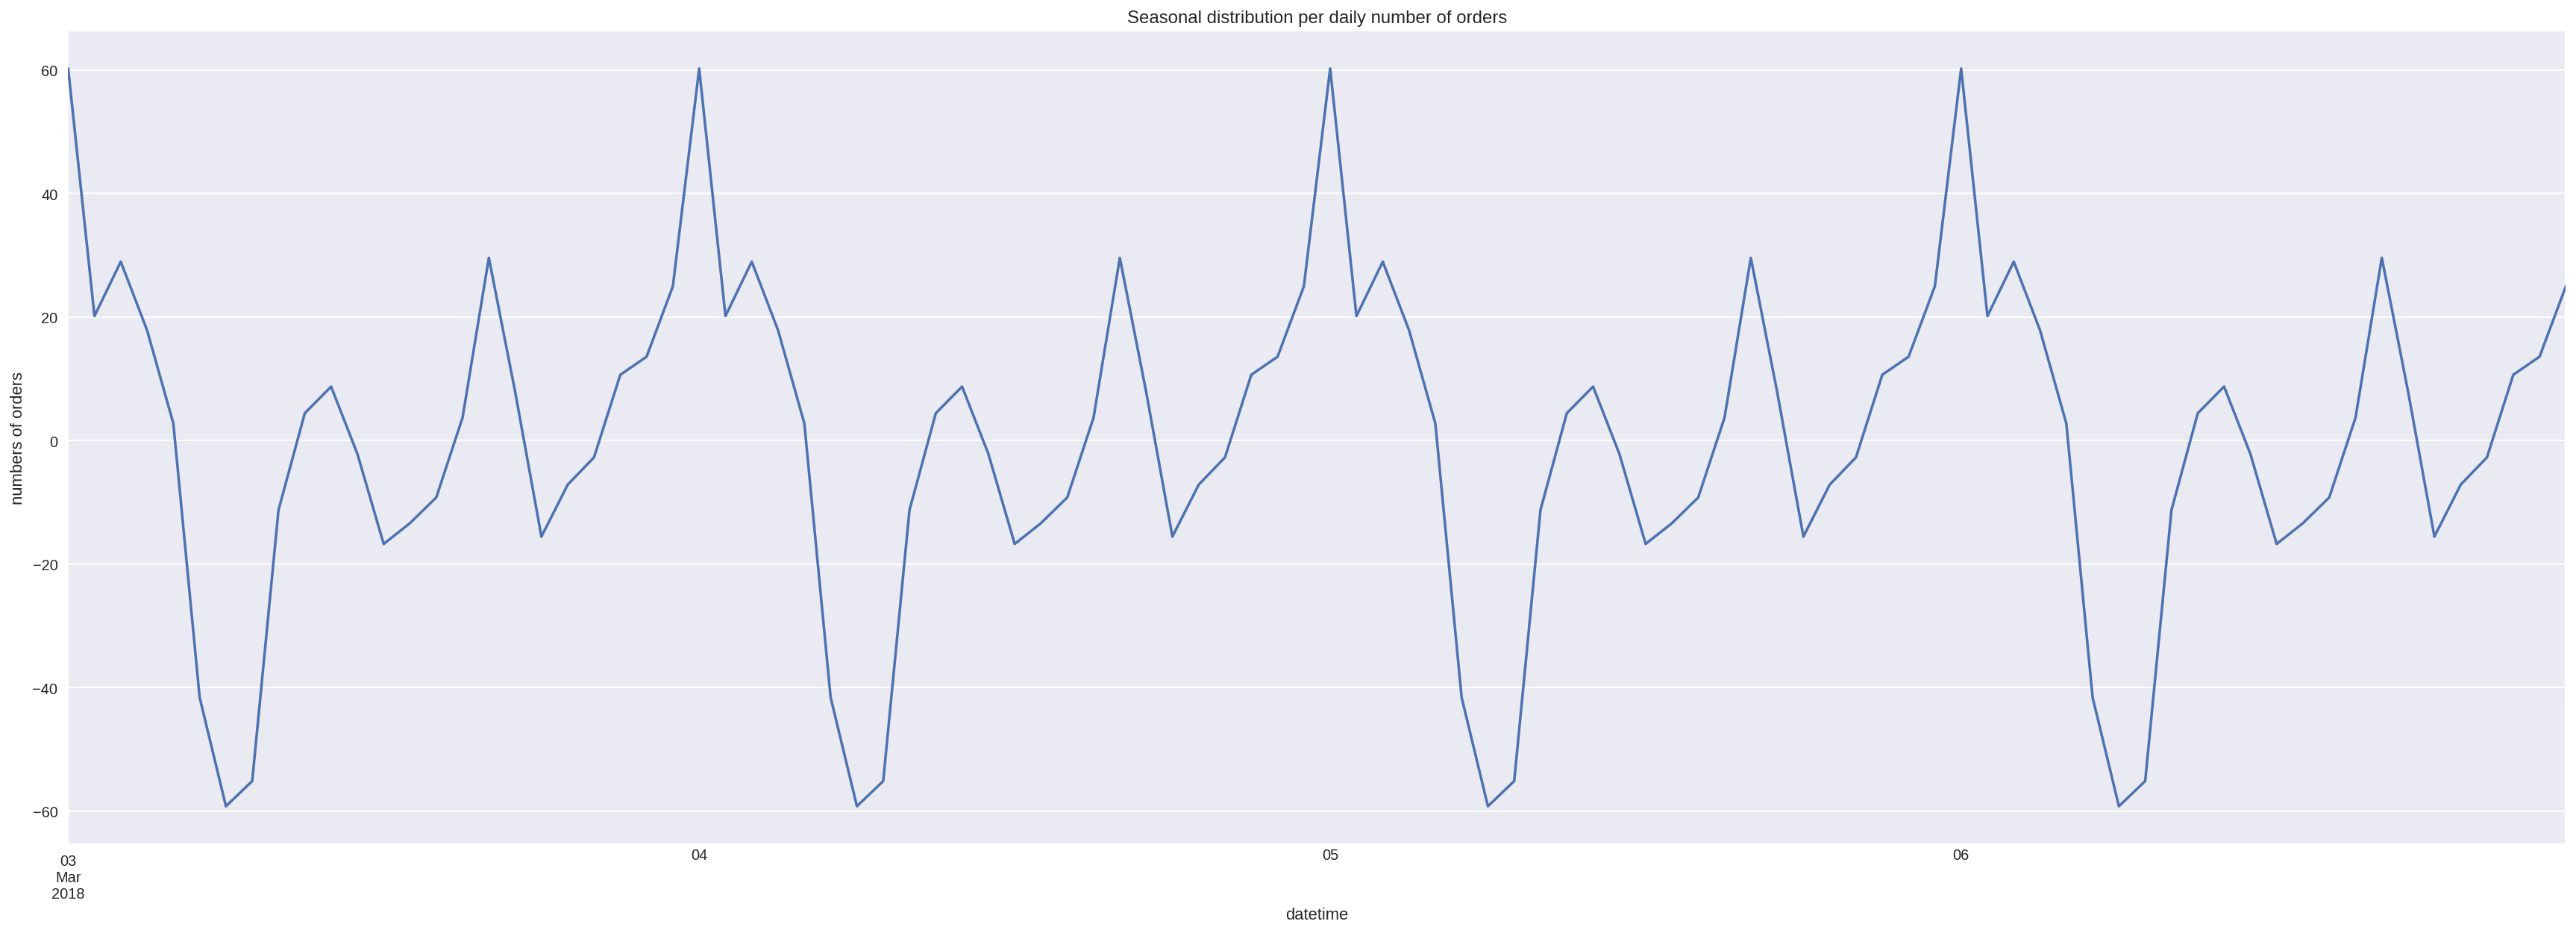

In [22]:
#seasonlity in the month of march, subsampled per hour. 
decomposed_hr = seasonal_decompose(data.resample('1H').sum())
decomposed_hr.seasonal['2018-03-03':'2018-03-06'].plot(figsize=(30,10))
plt.title('Seasonal distribution per daily number of orders')
plt.ylabel('numbers of orders')
plt.show()

In [23]:
decomposed_hr.seasonal['2018-03-04':'2018-03-06'].max()

60.248112097753484

In this section, we observed the mean and standard deviation of number of orders, with rolling mean and window size of 144 hours. The average and the standardard deviation were not stationary because both were increasing over time. We analyzed how the values of on shift() function affected the distribution of time series, when completing time series differences.  

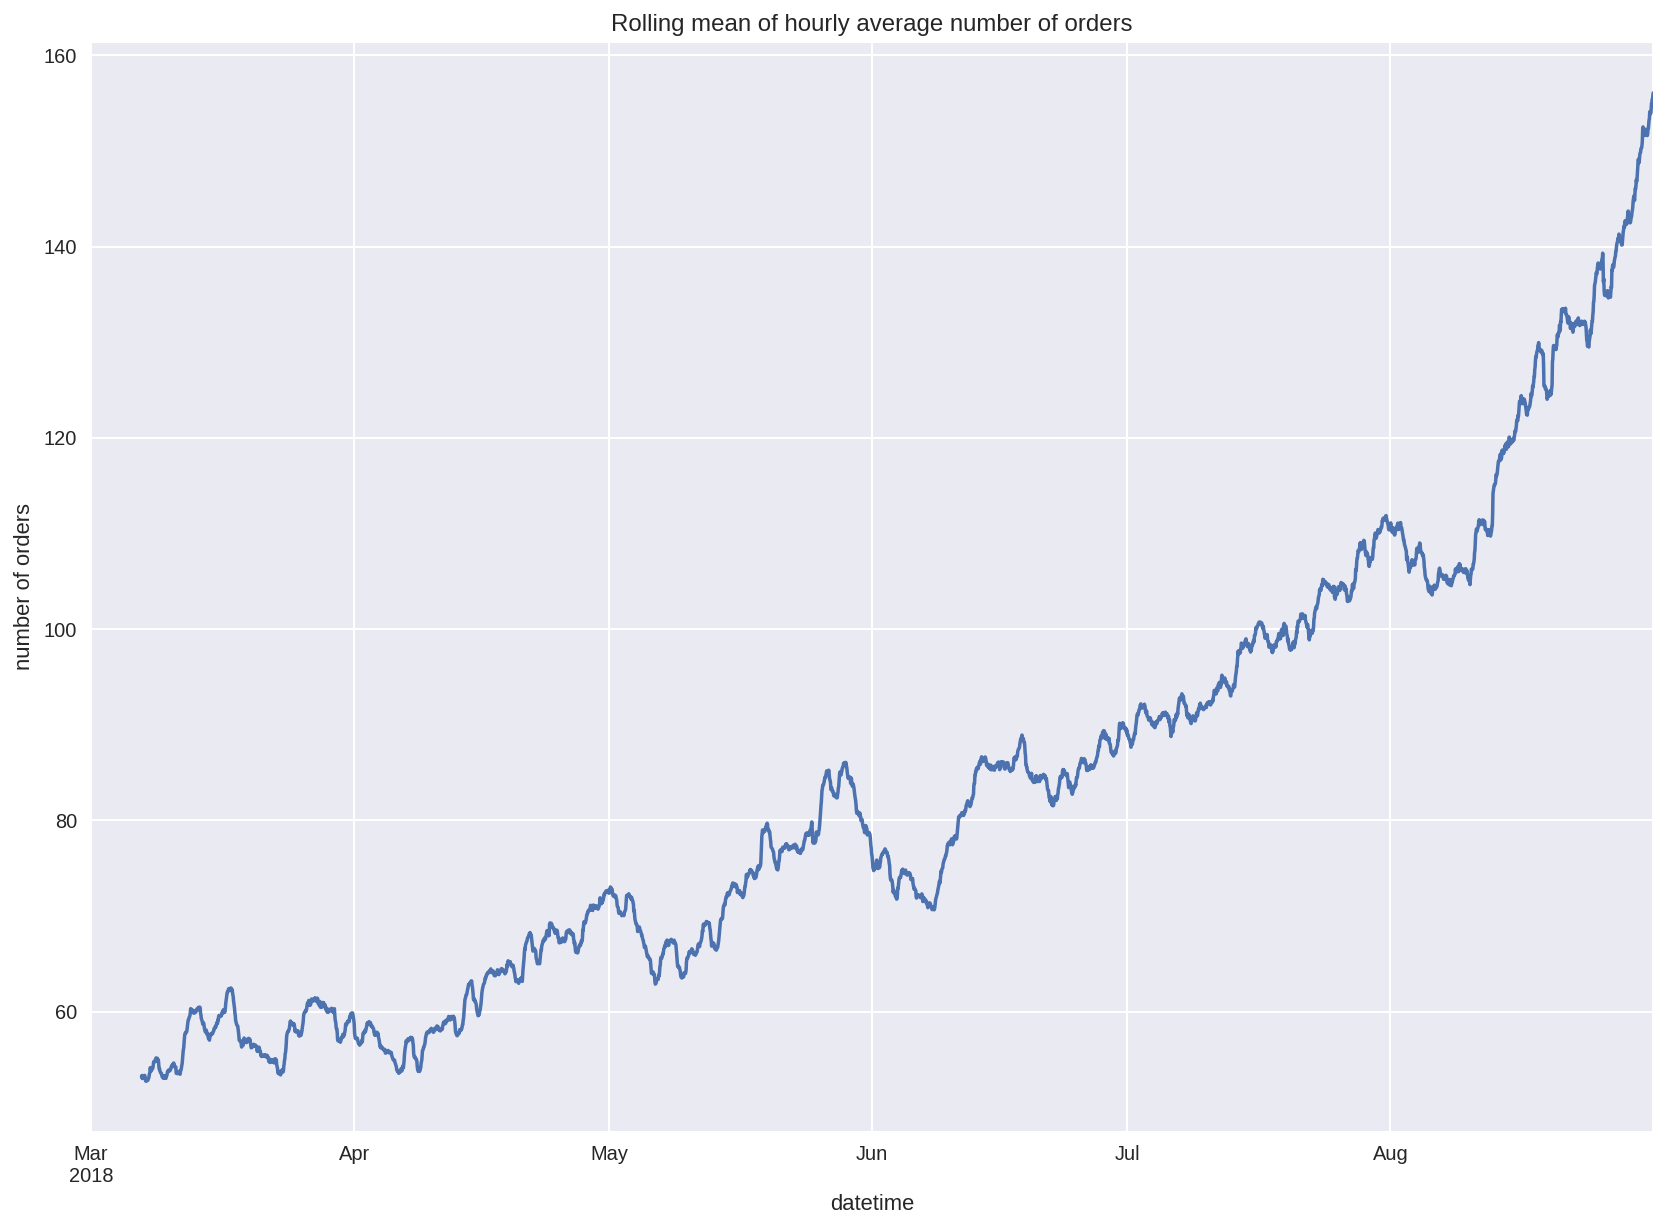

In [24]:
#rolling mean 
data.num_orders.rolling(144).mean().plot(figsize=(14,10))
plt.title('Rolling mean of hourly average number of orders')
plt.ylabel('number of orders')
plt.show()

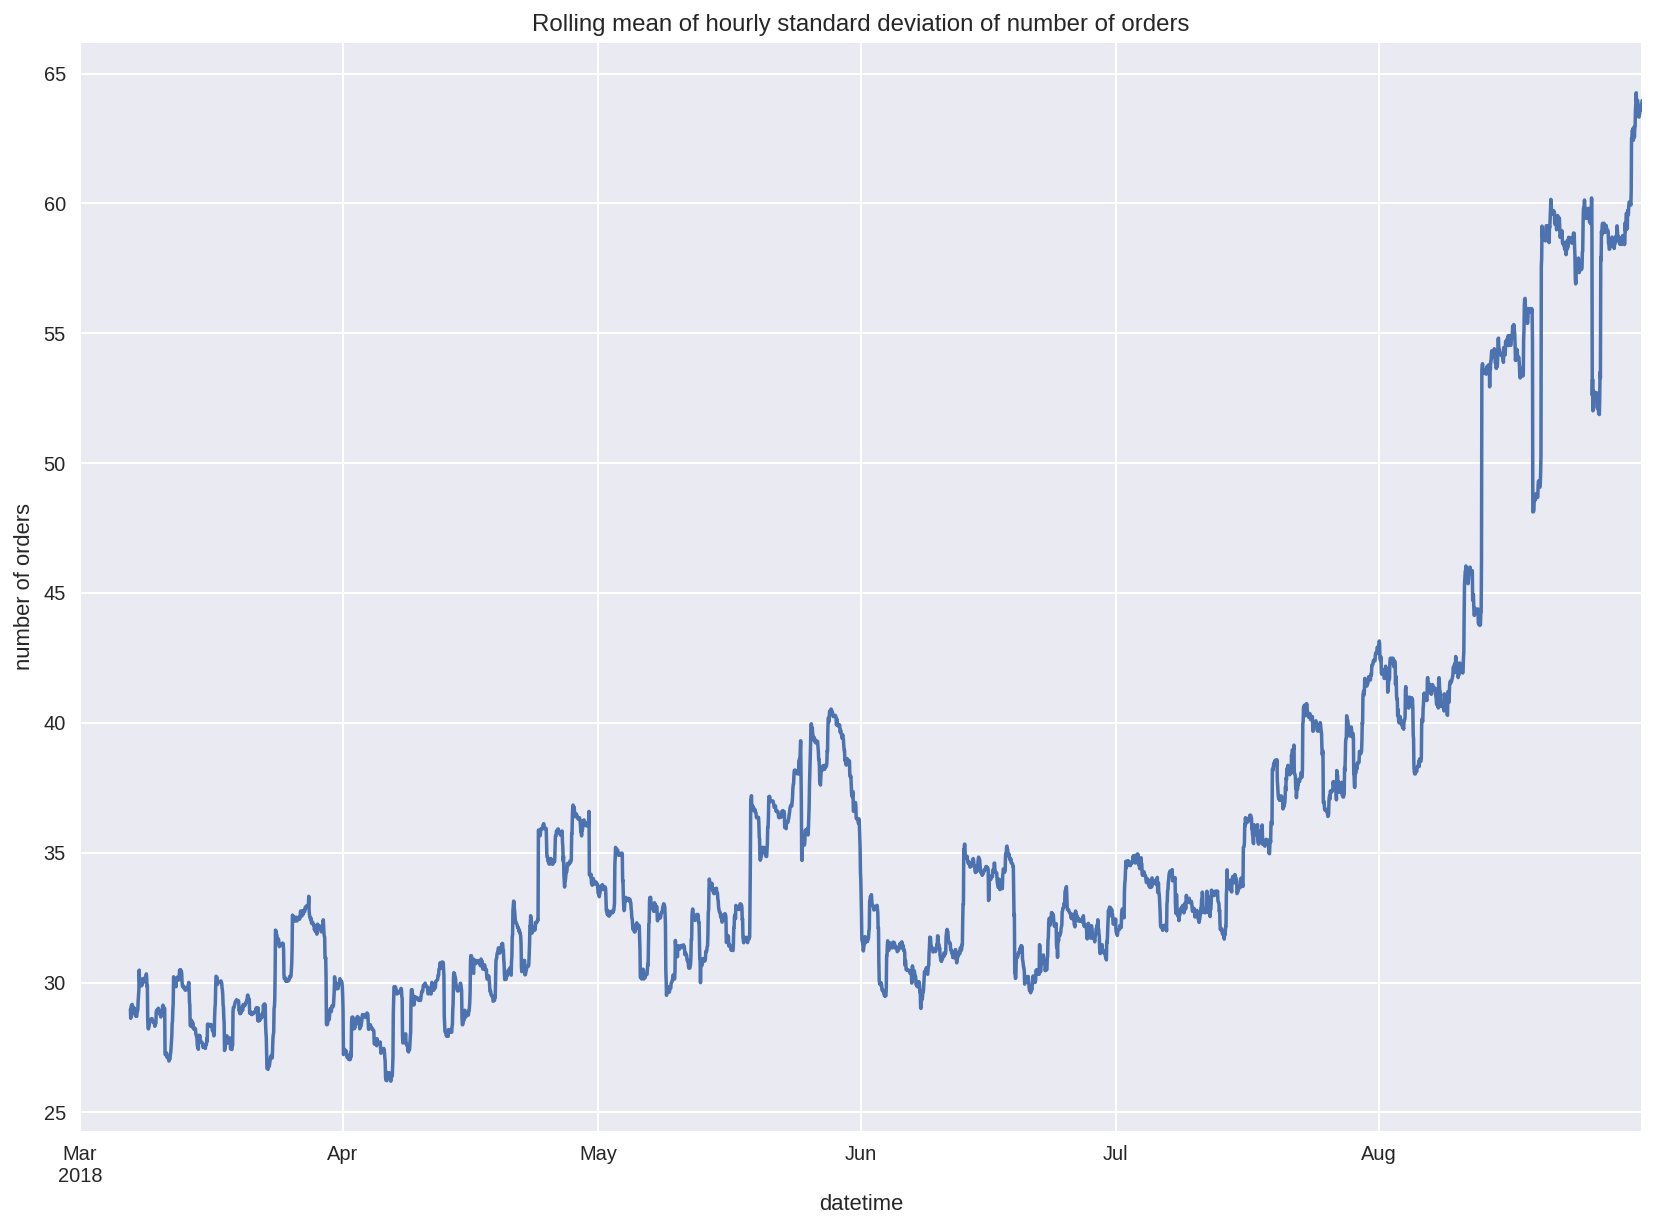

In [25]:
data.num_orders.rolling(144).std().plot(figsize=(14,10))
plt.title('Rolling mean of hourly standard deviation of number of orders')
plt.ylabel('number of orders')
plt.show()

In [26]:
stationary_data = data.resample('1H').sum()
stationary_data

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]

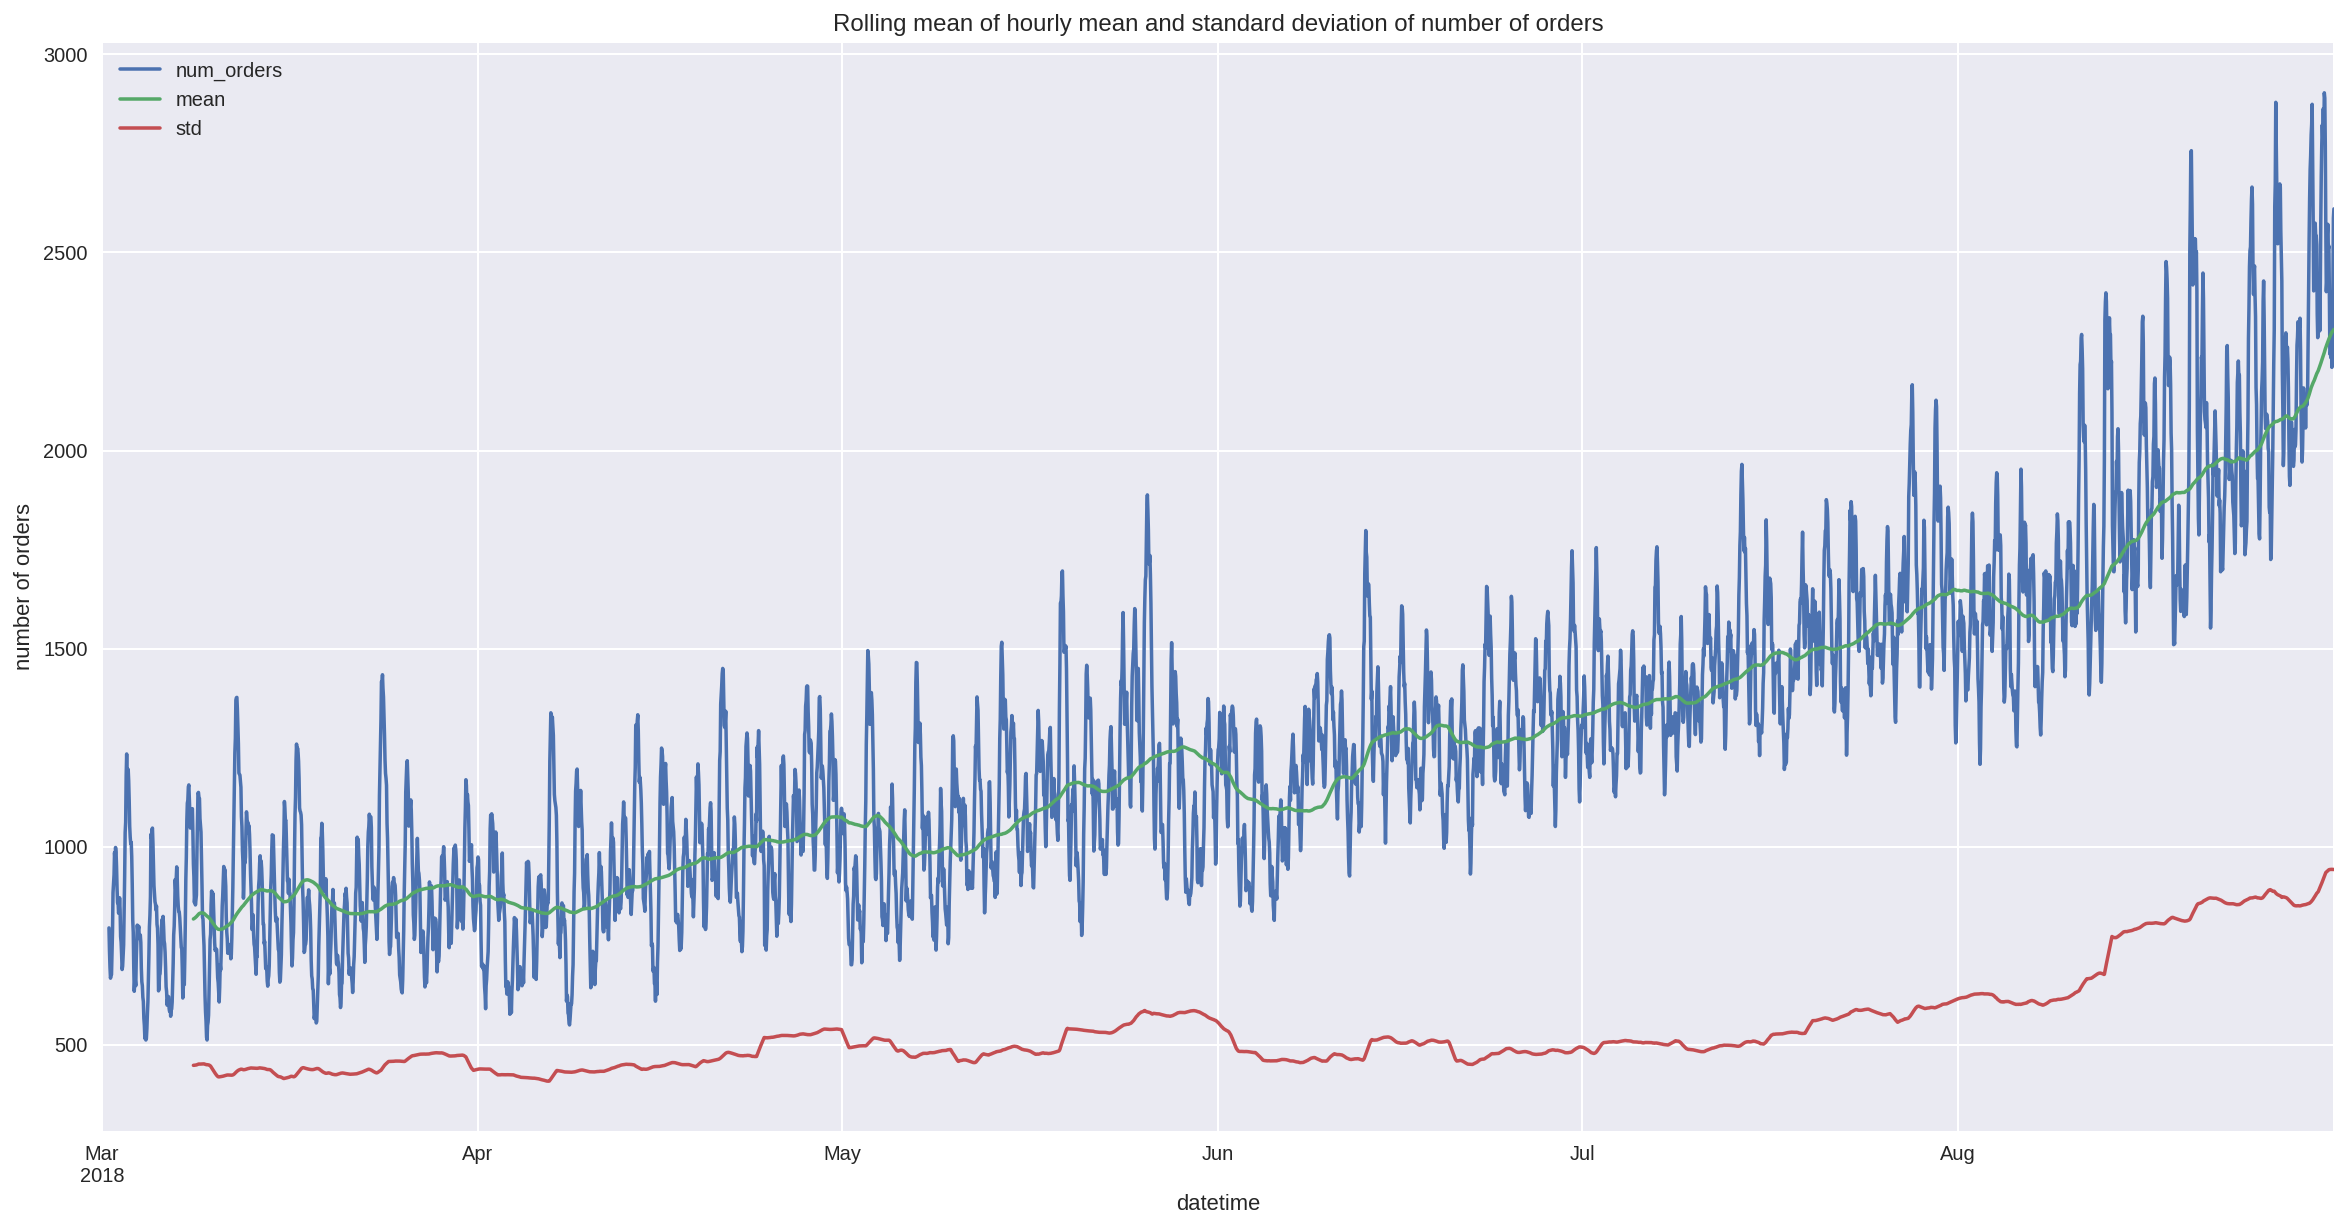

In [27]:
stationary_data_na =  stationary_data 
stationary_data_na['mean'] = stationary_data_na['num_orders'].rolling(168).mean()
stationary_data_na['std'] = stationary_data_na['num_orders'].rolling(168).std()
stationary_data_na.rolling(15).sum().plot(figsize=(20,10))
plt.ylabel('number of orders')
plt.title('Rolling mean of hourly mean and standard deviation of number of orders')
plt.plot()
plt.show()

In [28]:
station_data_shift_na_mean = stationary_data_na['mean'].std()
station_data_shift_na_mean

23.265292480291095

In [29]:
station_data_shift_na_std = stationary_data_na['std'].std()
station_data_shift_na_std

8.083638373161637

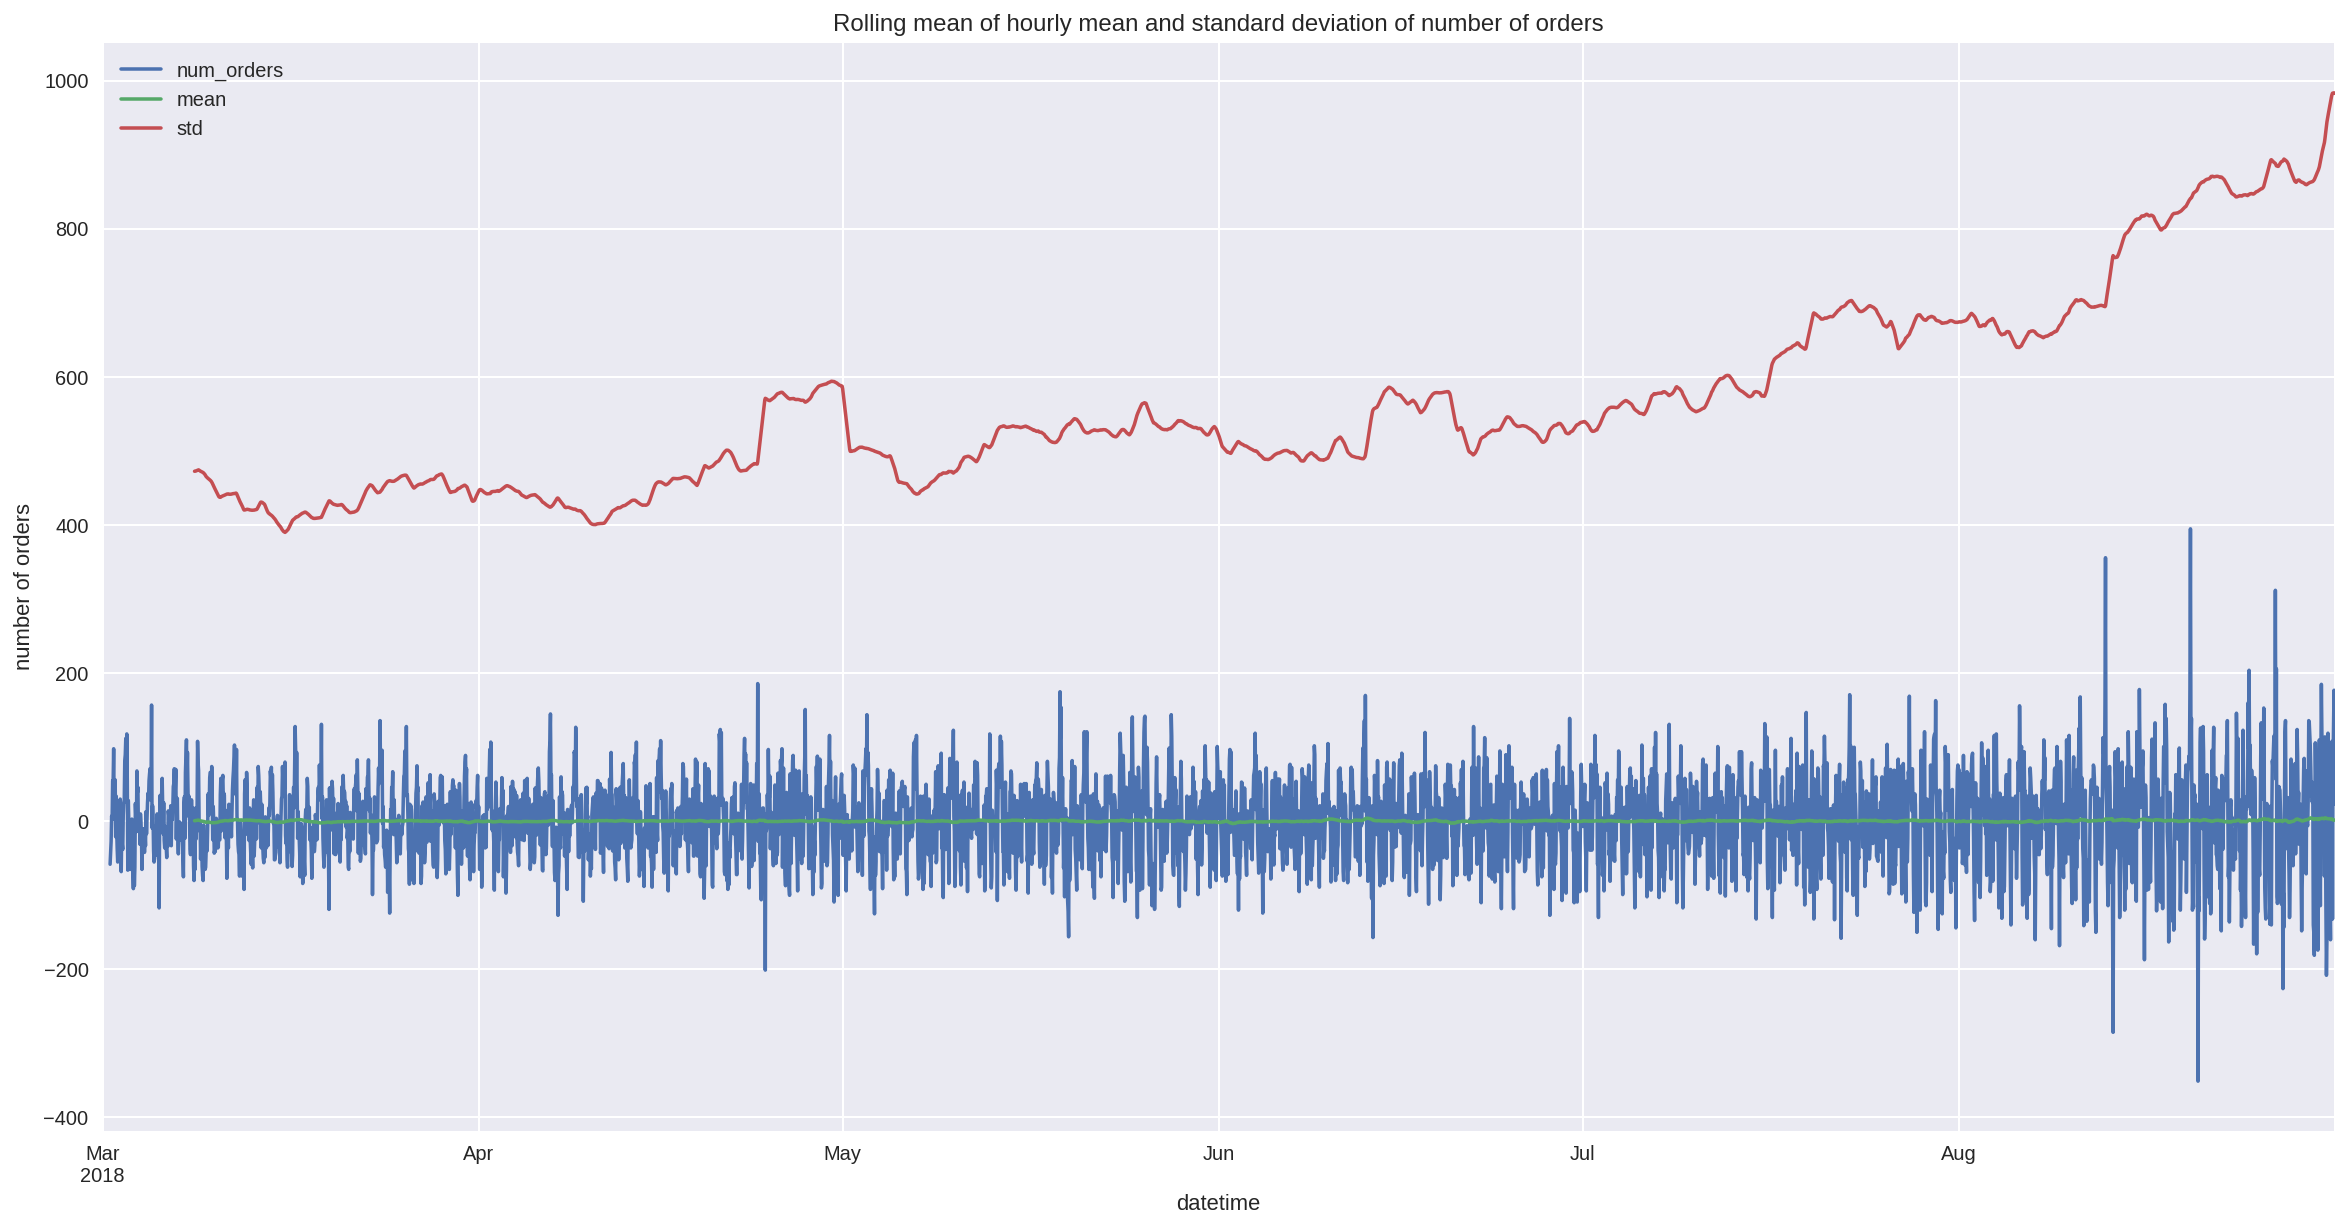

In [30]:
#make series stationary

stationary_data_1 =  stationary_data - stationary_data.shift()
stationary_data_1['mean'] = stationary_data_1['num_orders'].rolling(168).mean()
stationary_data_1['std'] = stationary_data_1['num_orders'].rolling(168).std()
stationary_data_1.rolling(15).sum().plot(figsize=(20,10))
plt.ylabel('number of orders')
plt.title('Rolling mean of hourly mean and standard deviation of number of orders')
plt.plot()
plt.show()

In [31]:
station_data_shift_1_mean = stationary_data_1['mean'].std()
station_data_shift_1_mean

0.1624493740505029

In [32]:
station_data_shift_1_std = stationary_data_1['std'].std()
station_data_shift_1_std

8.448794084166108

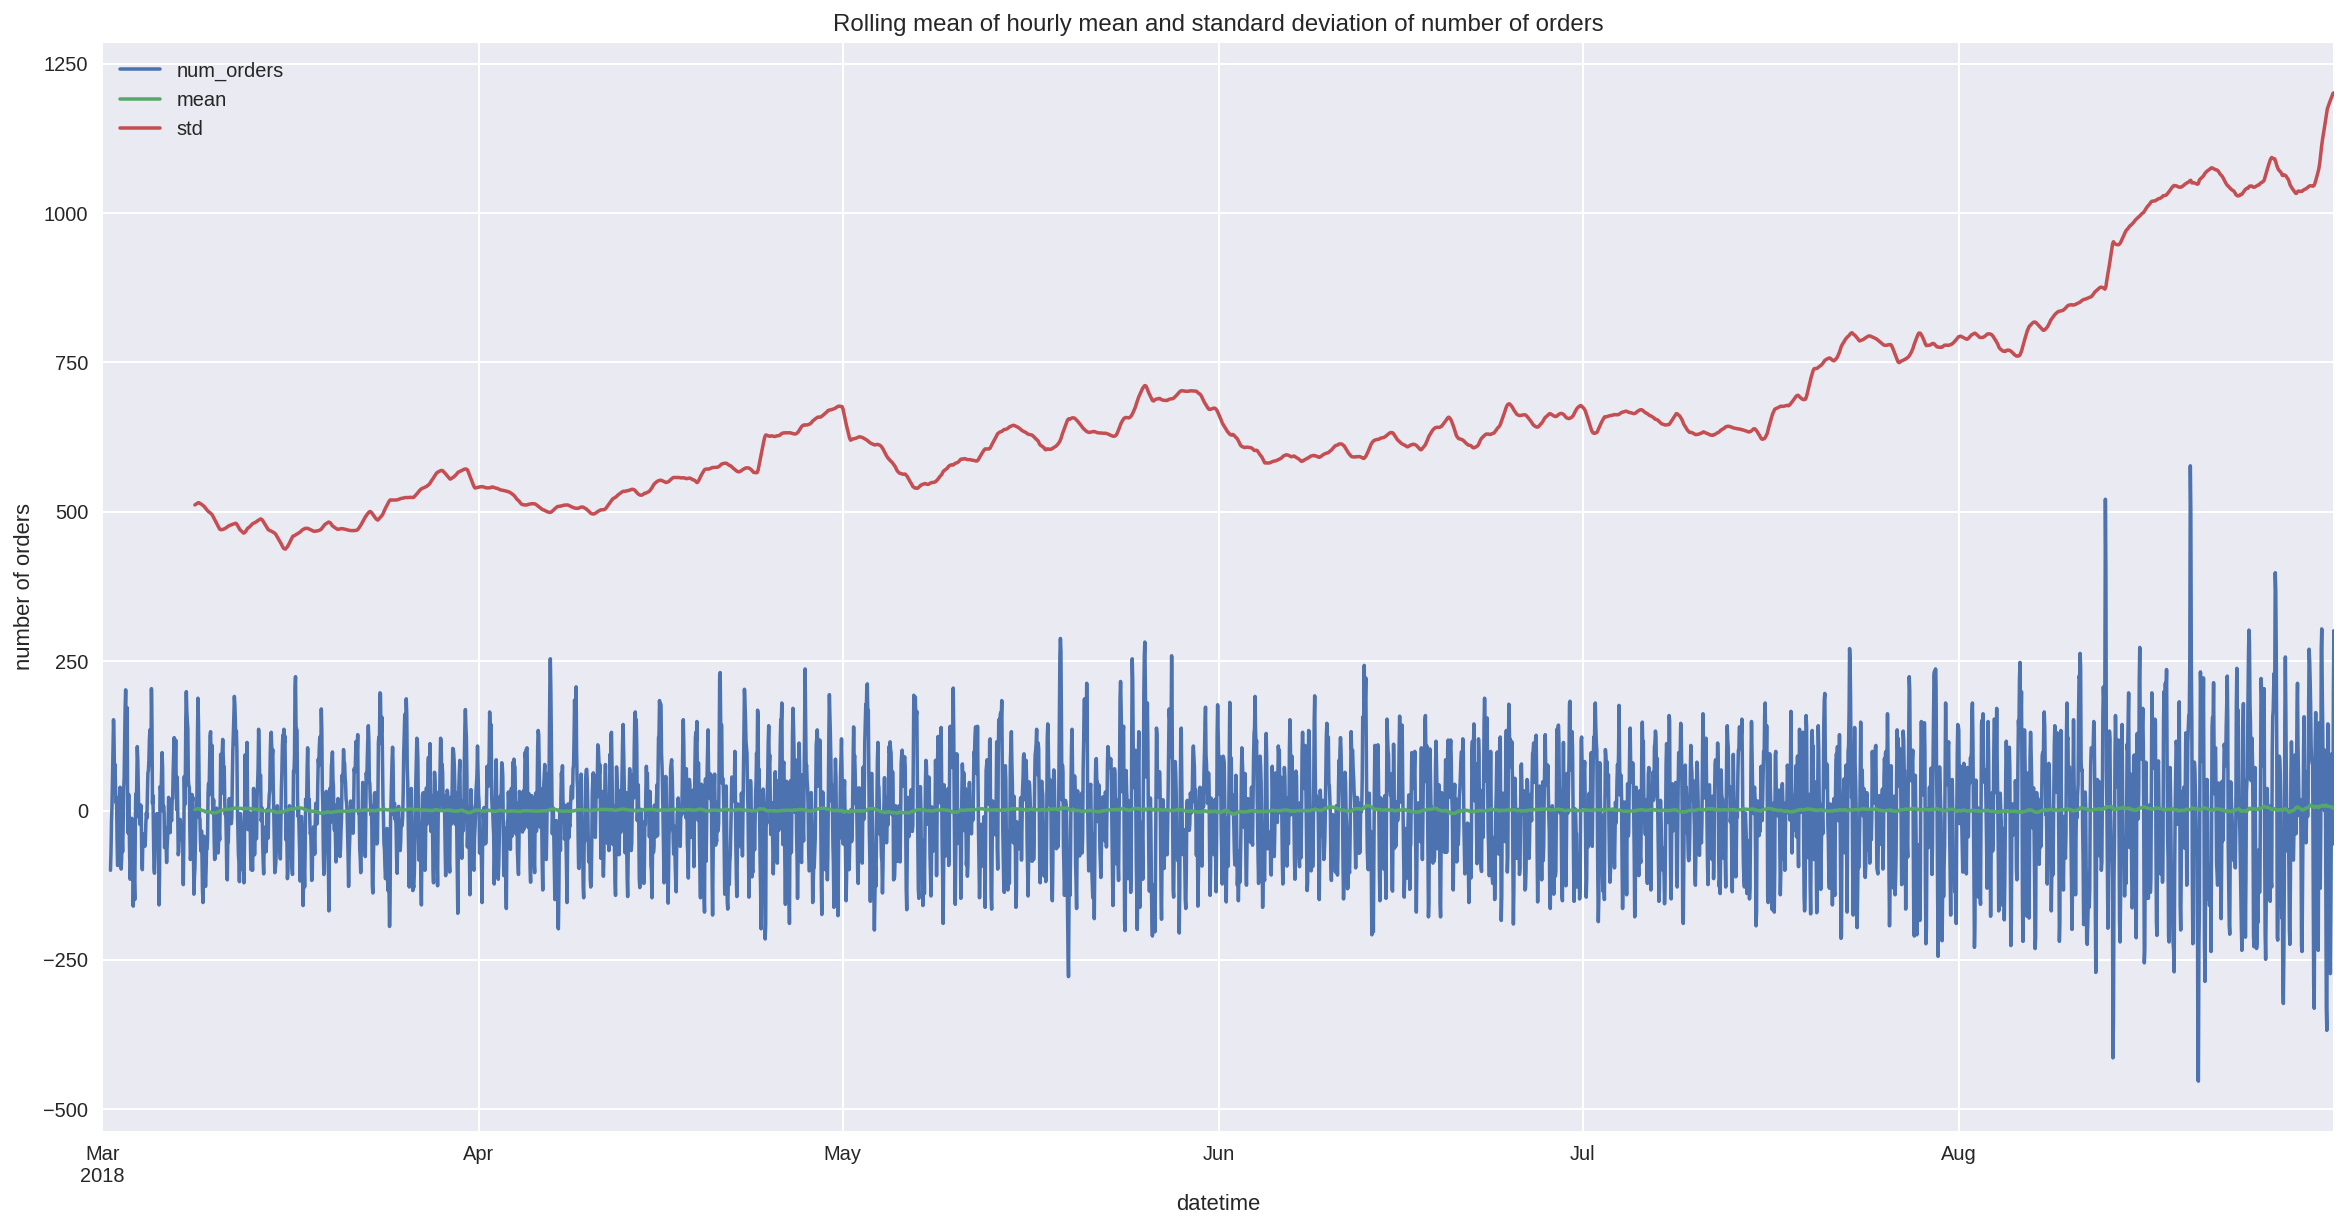

In [33]:
stationary_data_2 =  stationary_data - stationary_data.shift(2)
                                                          
stationary_data_2['mean'] = stationary_data_2['num_orders'].rolling(168).mean()
stationary_data_2['std'] = stationary_data_2['num_orders'].rolling(168).std()
stationary_data_2.rolling(15).sum().plot(figsize=(20,10))
plt.ylabel('number of orders')
plt.title('Rolling mean of hourly mean and standard deviation of number of orders')
plt.plot()
plt.show()

In [34]:
station_data_shift_2_mean = stationary_data_2['mean'].std()
station_data_shift_2_mean

0.2416935926900817

In [35]:
station_data_shift_2_std = stationary_data_2['std'].std()
station_data_shift_2_std

10.648535828283334

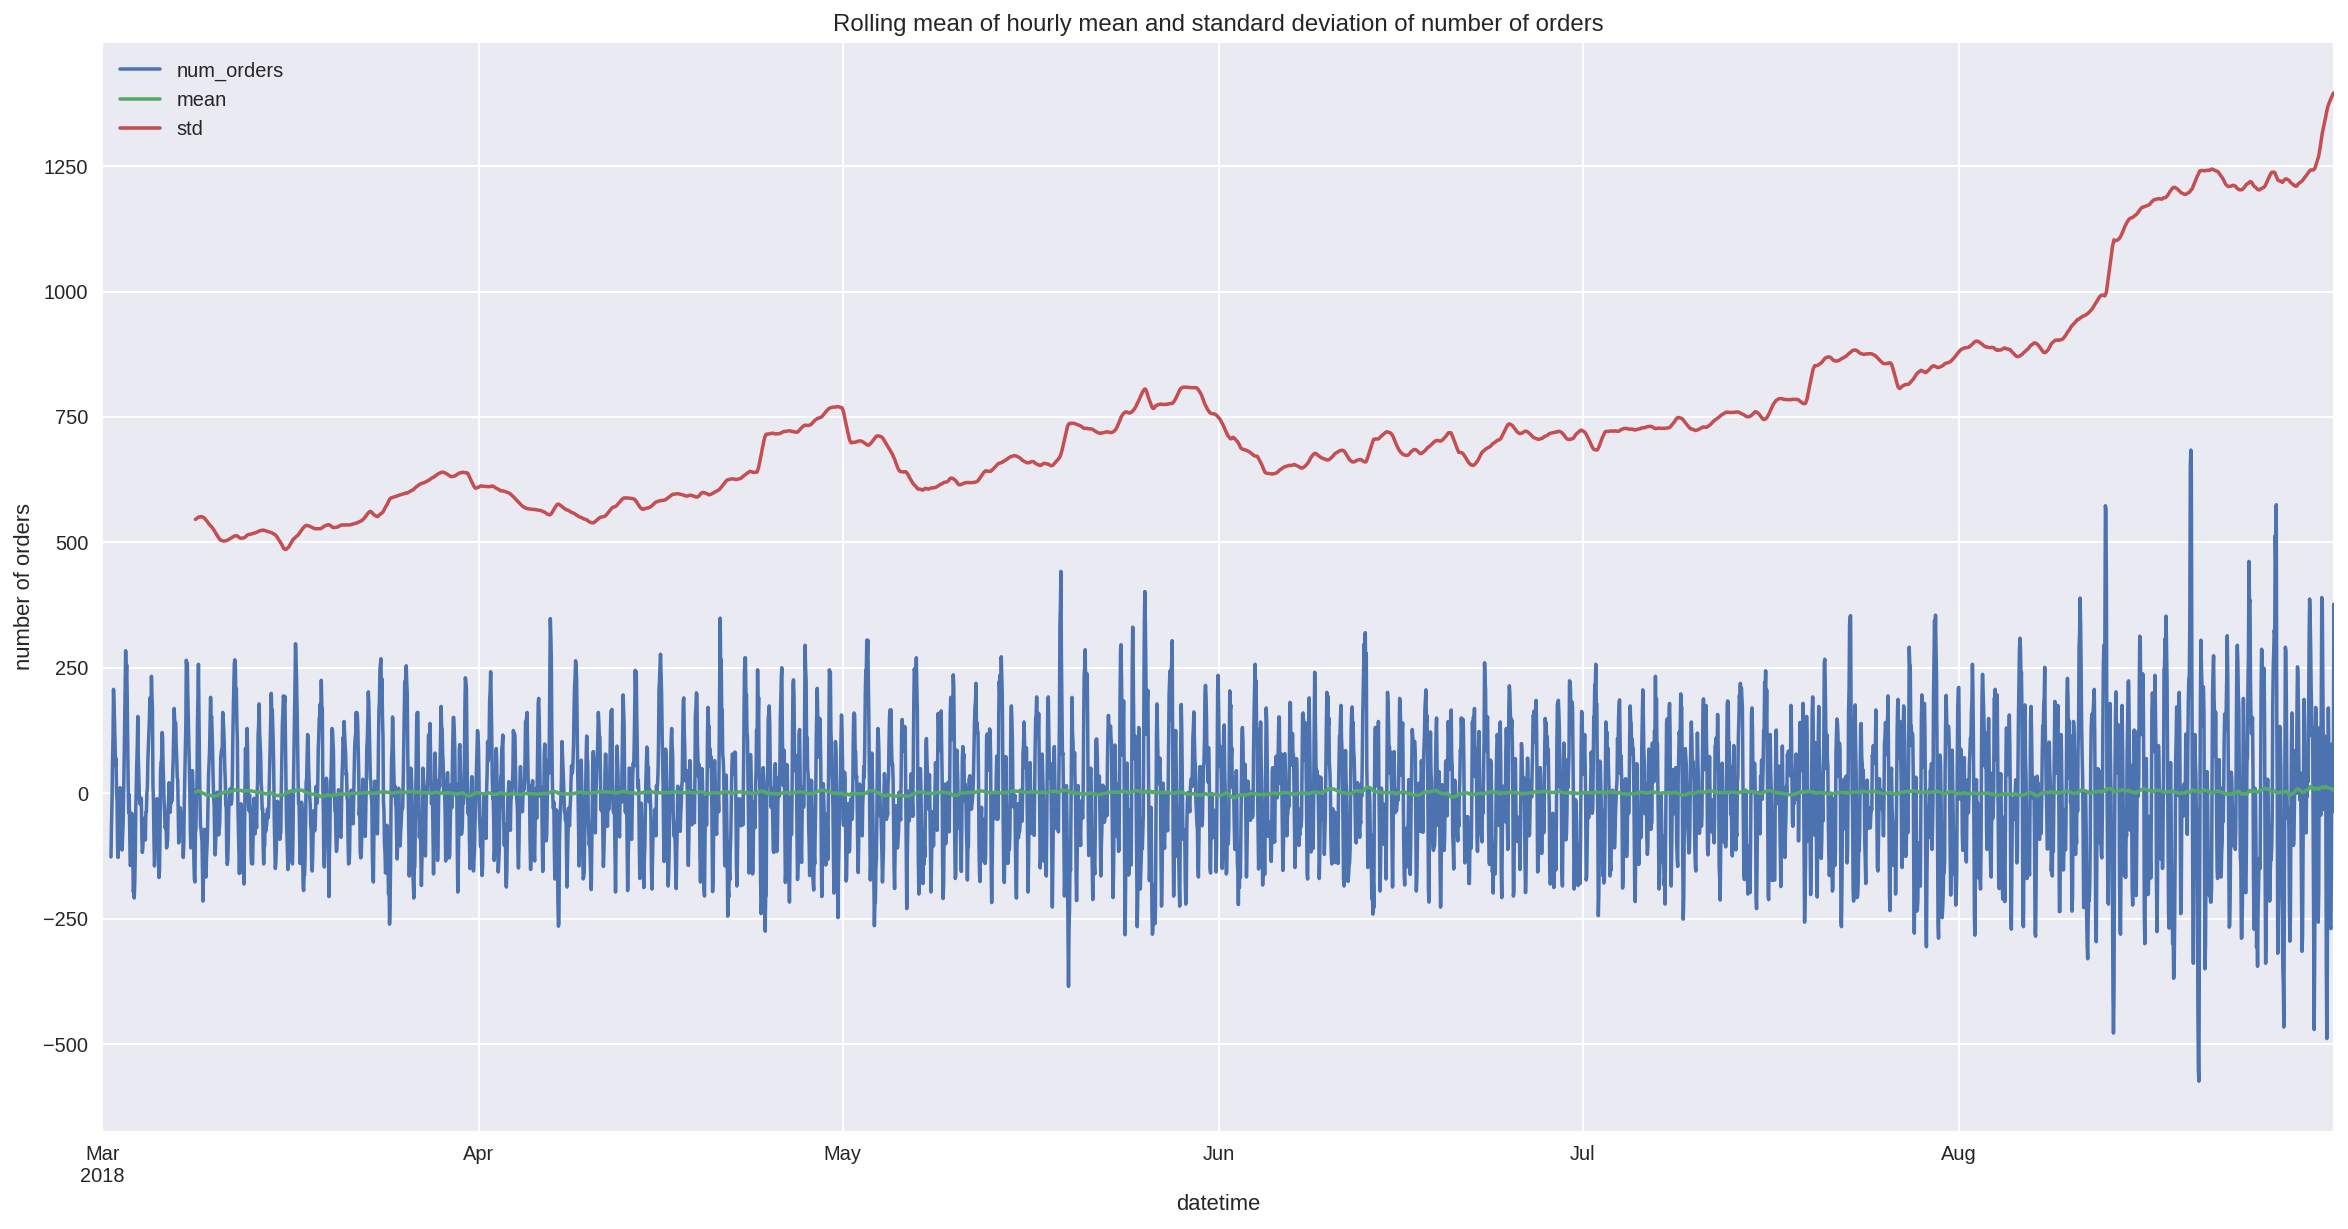

In [36]:
stationary_data_3 =  stationary_data - stationary_data.shift(3)
                                                          
stationary_data_3['mean'] = stationary_data_3['num_orders'].rolling(168).mean()
stationary_data_3['std'] = stationary_data_3['num_orders'].rolling(168).std()
stationary_data_3.rolling(15).sum().plot(figsize=(20,10))
plt.ylabel('number of orders')
plt.title('Rolling mean of hourly mean and standard deviation of number of orders')
plt.plot()
plt.show()

In [37]:
station_data_shift_3_mean = stationary_data_3['mean'].std()
station_data_shift_3_mean

0.3091886721353508

In [38]:
station_data_shift_3_std = stationary_data_3['std'].std()
station_data_shift_3_std

12.811383974906487

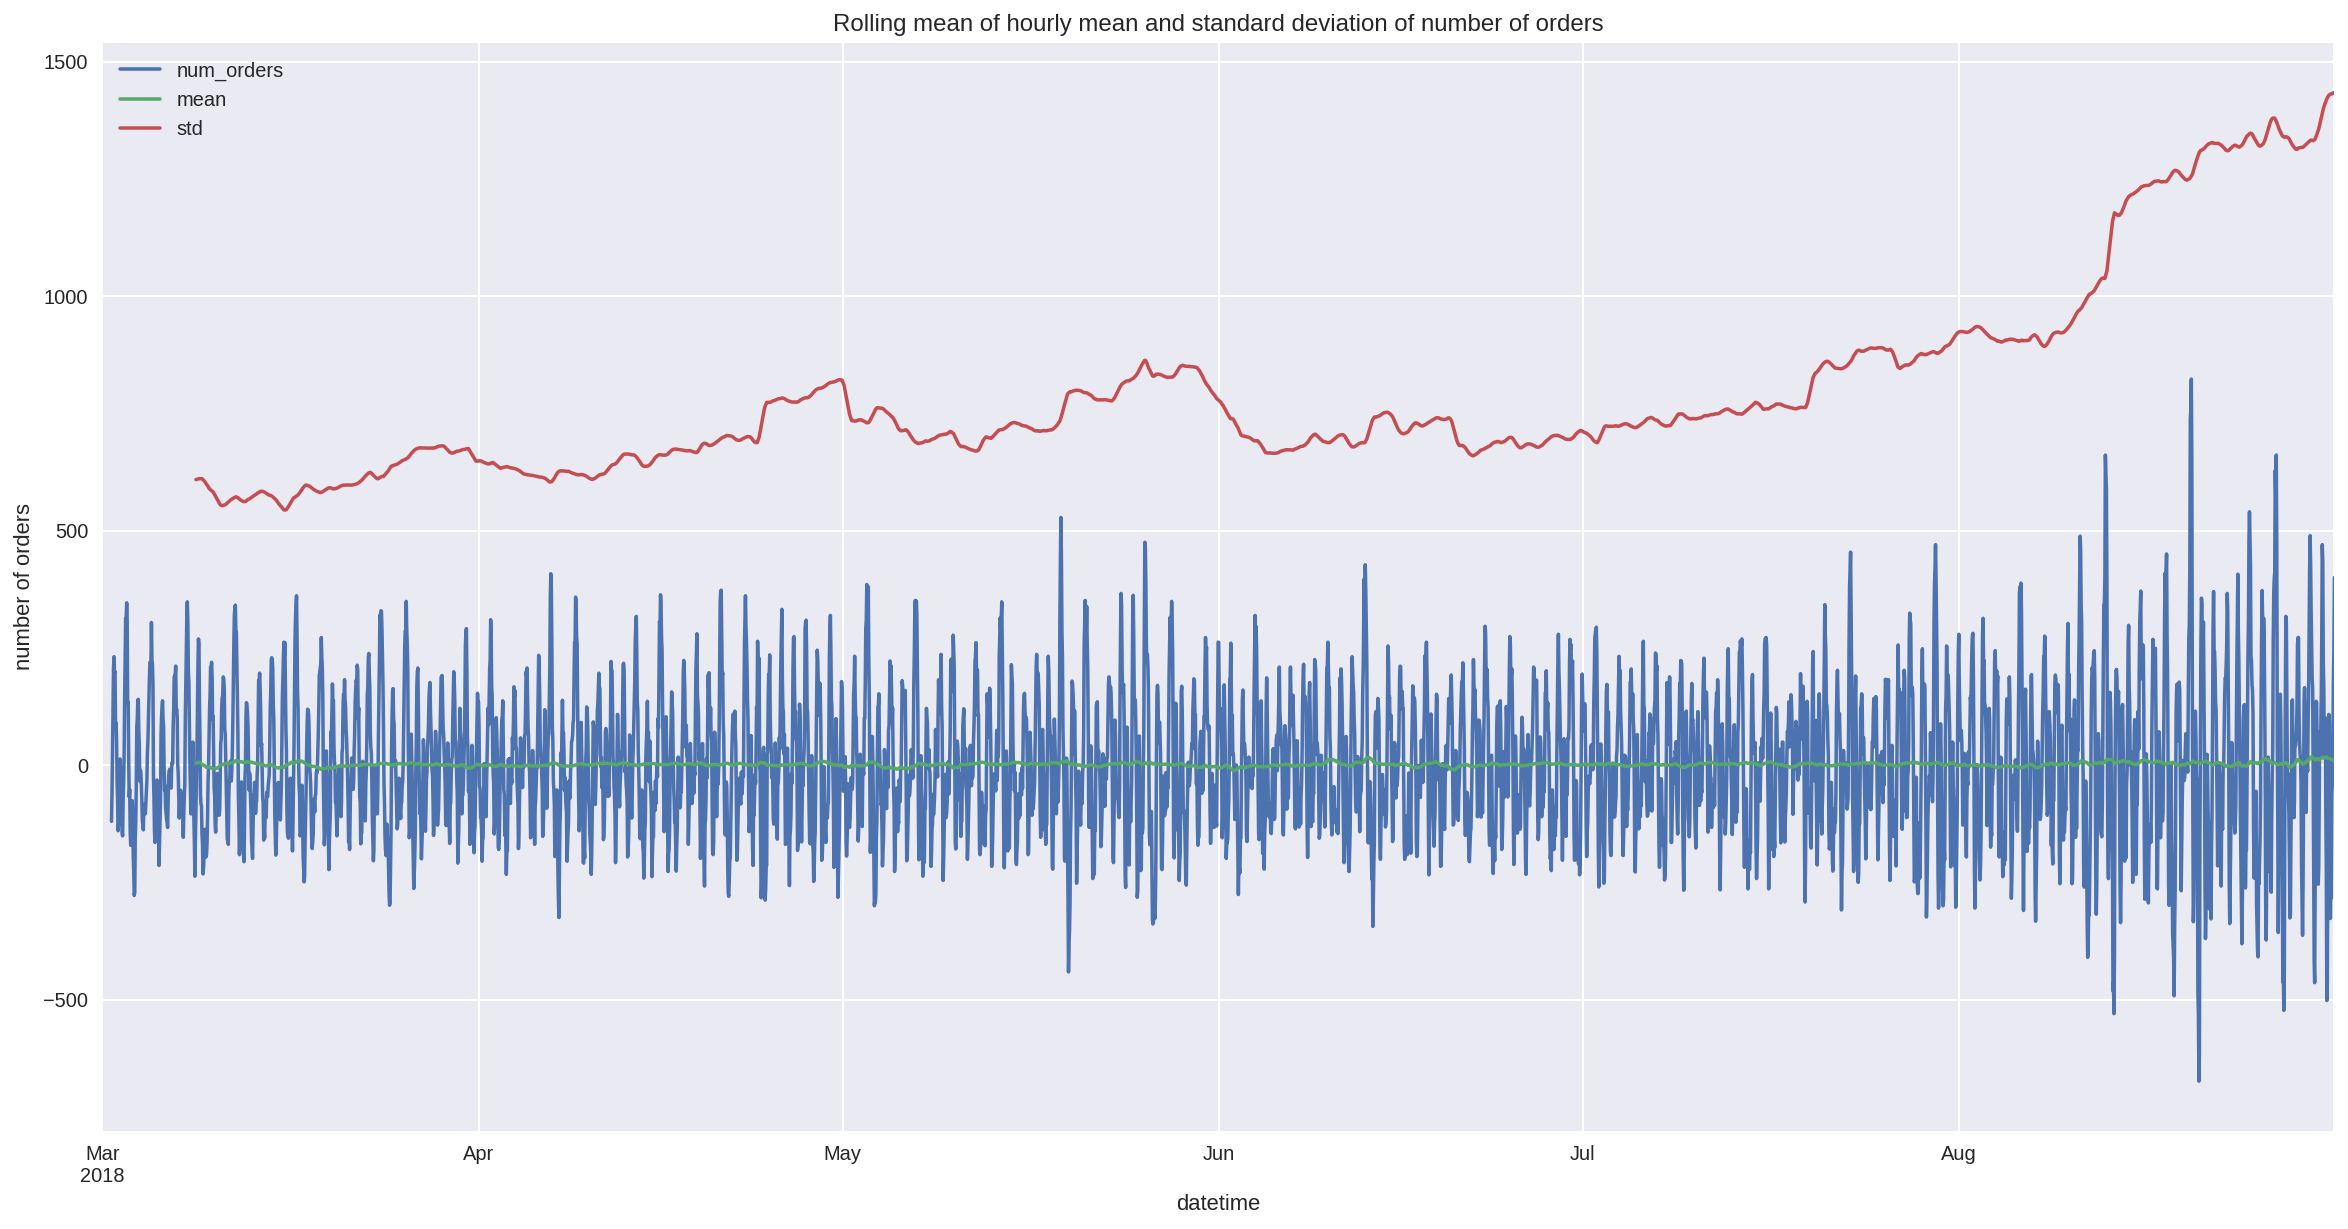

In [39]:
stationary_data_4 =  stationary_data - stationary_data.shift(4)
                                                          
stationary_data_4['mean'] = stationary_data_4['num_orders'].rolling(168).mean()
stationary_data_4['std'] = stationary_data_4['num_orders'].rolling(168).std()
stationary_data_4.rolling(15).sum().plot(figsize=(20,10))
plt.ylabel('number of orders')
plt.title('Rolling mean of hourly mean and standard deviation of number of orders')
plt.plot()
plt.show()

In [40]:
station_data_shift_4_mean = stationary_data_4['mean'].std()
station_data_shift_4_mean

0.3723782769229283

In [41]:
station_data_shift_4_std = stationary_data_4['std'].std()
station_data_shift_4_std

13.32918556830416

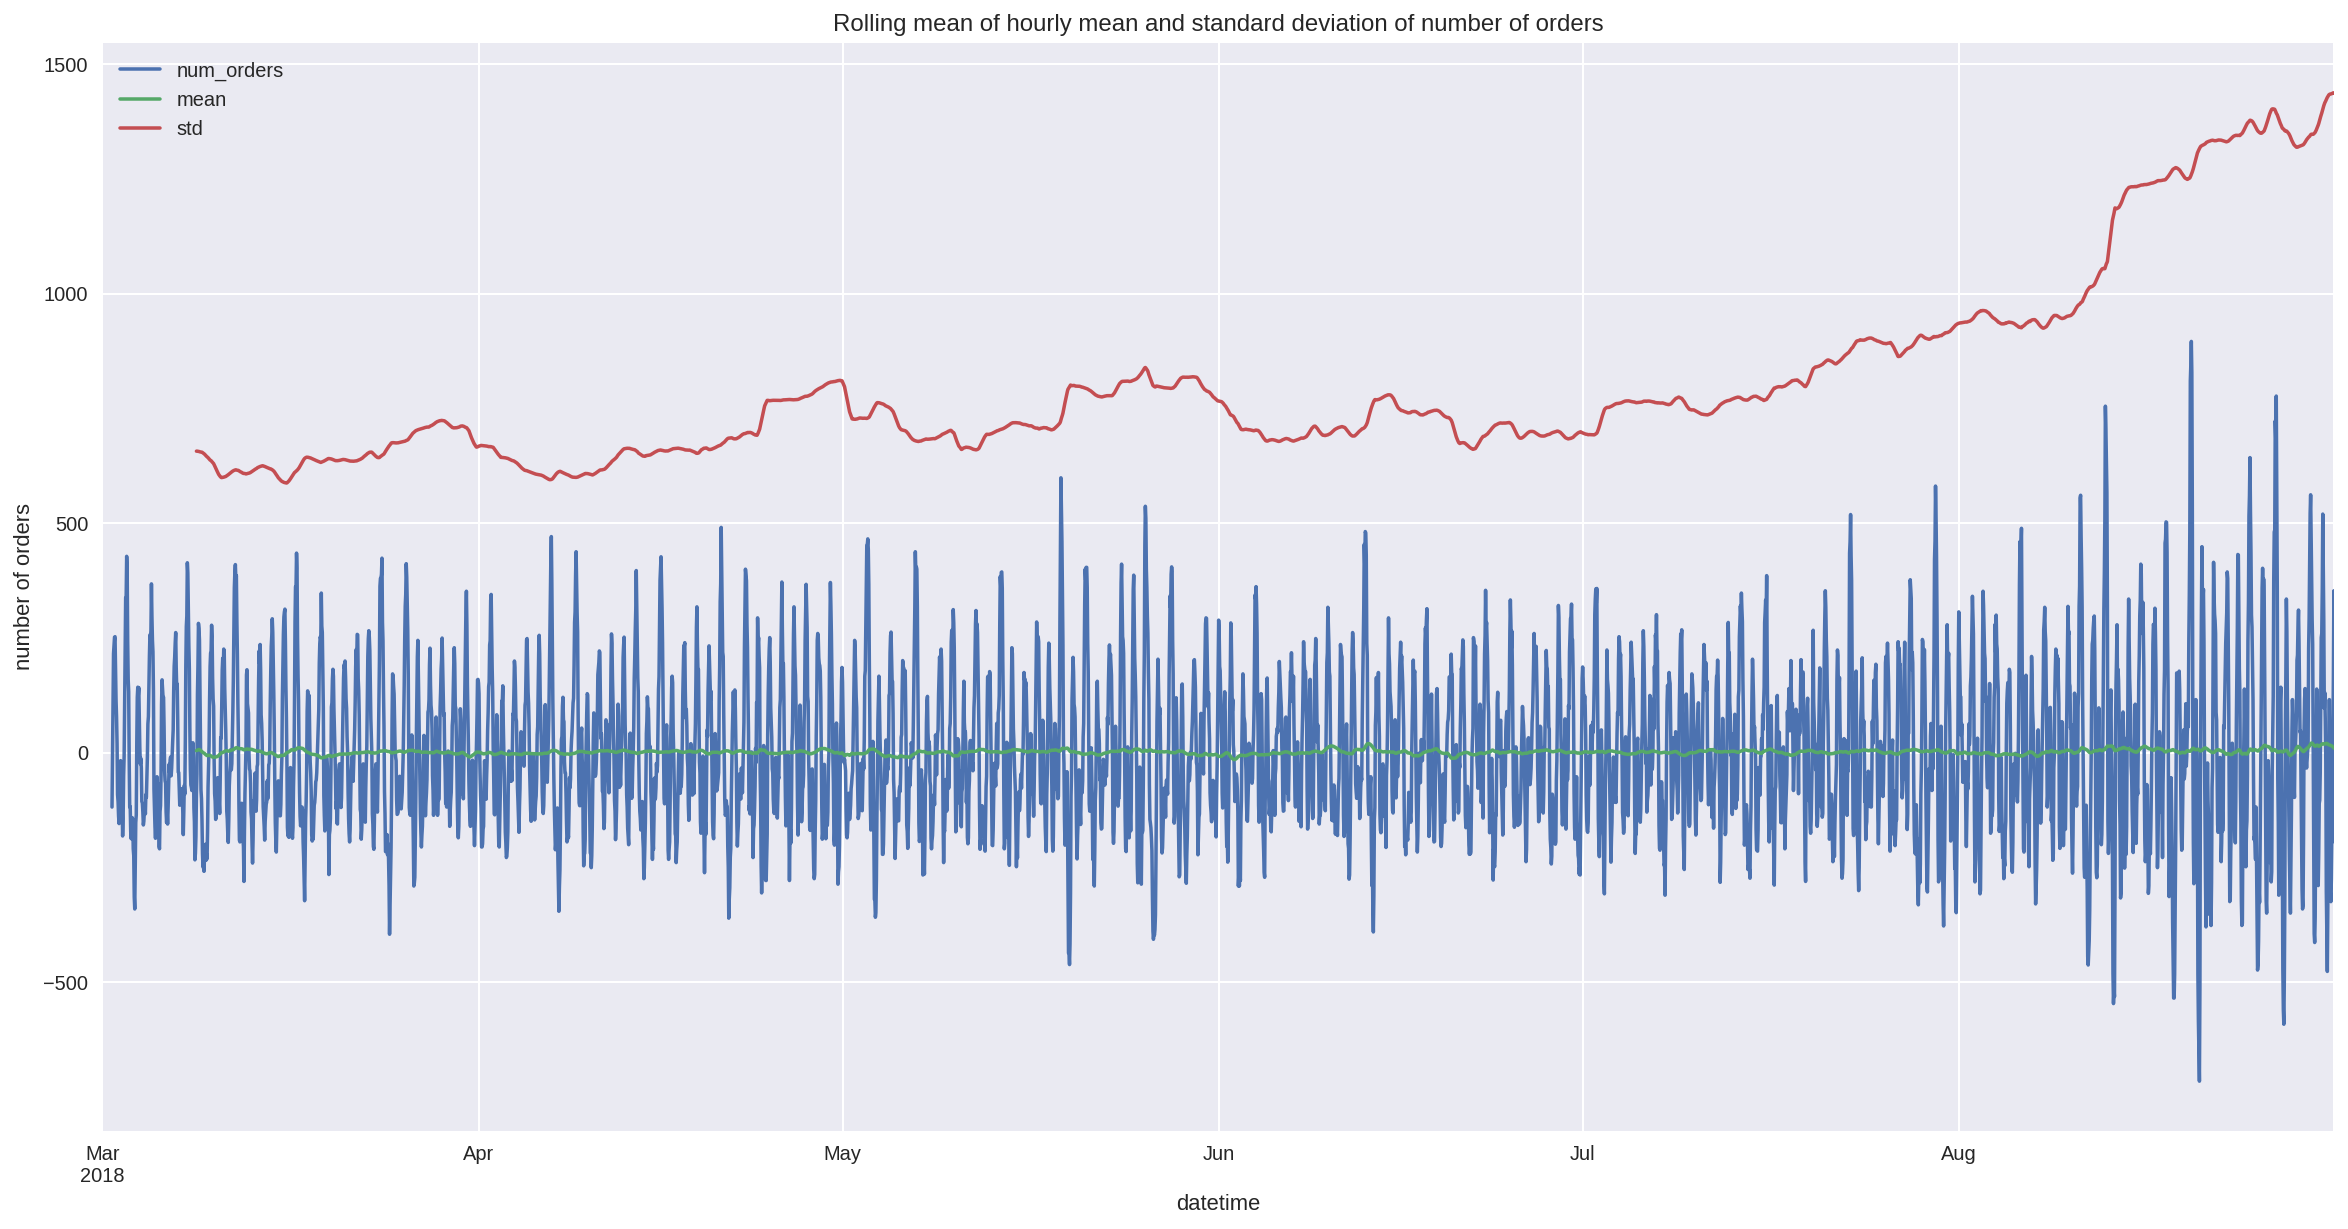

In [42]:
stationary_data_5 =  stationary_data - stationary_data.shift(5)
                                                          
stationary_data_5['mean'] = stationary_data_5['num_orders'].rolling(168).mean()
stationary_data_5['std'] = stationary_data_5['num_orders'].rolling(168).std()
stationary_data_5.rolling(15).sum().plot(figsize=(20,10))
plt.ylabel('number of orders')
plt.title('Rolling mean of hourly mean and standard deviation of number of orders')
plt.plot()
plt.show()

In [43]:
station_data_shift_5_mean = stationary_data_5['mean'].std()
station_data_shift_5_mean

0.432609717398781

In [44]:
station_data_shift_5_std = stationary_data_5['std'].std()
station_data_shift_5_std

13.344393918410166

## Training

In [45]:
#creating features for training
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1): 
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())
    
make_features(data,10,12)
data

num_orders  month  day  day_of_week  hour  lag_1  lag_2  \
datetime                                                                       
2018-03-01 00:00:00         124      3    1            3     0    NaN    NaN   
2018-03-01 01:00:00          85      3    1            3     1  124.0    NaN   
2018-03-01 02:00:00          71      3    1            3     2   85.0  124.0   
2018-03-01 03:00:00          66      3    1            3     3   71.0   85.0   
2018-03-01 04:00:00          43      3    1            3     4   66.0   71.0   
...                         ...    ...  ...          ...   ...    ...    ...   
2018-08-31 19:00:00         136      8   31            4    19  207.0  217.0   
2018-08-31 20:00:00         154      8   31            4    20  136.0  207.0   
2018-08-31 21:00:00         159      8   31            4    21  154.0  136.0   
2018-08-31 22:00:00         223      8   31            4    22  159.0  154.0   
2018-08-31 23:00:00         205      8   31            4    23  223.0  159.0   

                     lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
datetime                                                                       
2018-03-01 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2018-03-01 03:00:00  124.0    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2018-03-01 04:00:00   85.0  124.0    NaN    NaN    NaN    NaN    NaN     NaN   
...                    ...    ...    ...    ...    ...    ...    ...     ...   
2018-08-31 19:00:00  197.0  116.0  133.0  166.0  136.0  167.0  191.0   203.0   
2018-08-31 20:00:00  217.0  197.0  116.0  133.0  166.0  136.0  167.0   191.0   
2018-08-31 21:00:00  207.0  217.0  197.0  116.0  133.0  166.0  136.0   167.0   
2018-08-31 22:00:00  136.0  207.0  217.0  197.0  116.0  133.0  166.0   136.0   
2018-08-31 23:00:00  154.0  136.0  207.0  217.0  197.0  116.0  133.0   166.0   

                     rolling_mean  
datetime                           
2018-03-01 00:00:00           NaN  
2018-03-01 01:00:00           NaN  
2018-03-01 02:00:00           NaN  
2018-03-01 03:00:00           NaN  
2018-03-01 04:00:00           NaN  
...                           ...  
2018-08-31 19:00:00    163.416667  
2018-08-31 20:00:00    170.916667  
2018-08-31 21:00:00    168.583333  
2018-08-31 22:00:00    164.916667  
2018-08-31 23:00:00    167.583333  

[4416 rows x 16 columns]

In [46]:
#creating trainining, validation, and test datasets from data

train_data, test_data = train_test_split(data, shuffle = False, test_size = 0.10)

In [47]:
print('train_data dimensions', train_data.shape, '\n', '% of data', len(train_data)/len(data), '\n')

print('test_data dimensions', test_data.shape,'\n', '% of data', len(test_data)/len(data))

train_data dimensions (3974, 16) 
 % of data 0.8999094202898551 

test_data dimensions (442, 16) 
 % of data 0.10009057971014493


In [48]:
#checking if split was performed correctly 
print(train_data.index.min(),train_data.index.max())
print(test_data.index.min(),test_data.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [49]:
#creating features and target for training, validation, and test data
train_data.dropna(inplace = True)
train_x = train_data.drop('num_orders', axis = 1)
train_y = train_data['num_orders']


test_x = test_data.drop('num_orders', axis = 1)
test_y = test_data['num_orders']

/tmp/ipykernel_118/909922483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.dropna(inplace = True)


### RadomForestRegressor Model

In [50]:
tscv_rf = TimeSeriesSplit(n_splits = 5)


In [51]:
#defining parameters
n_estimators = list(np.arange(0,60,2))
max_features = ['auto', 'sqrt']
max_depth = list(np.arange(0,30,2))
min_samples_split = list(np.arange(0,12,1))
min_samples_leaf = list(np.arange(1,10,1))
bootstrap = [False, True]

params_grid = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'max_depth' : max_depth, 
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap' : bootstrap}


In [52]:
rf_model = RandomForestRegressor(random_state=12345)
rf_random = RandomizedSearchCV(estimator = rf_model, 
                       param_distributions = params_grid,
                       cv = tscv_rf, 
                       scoring= 'neg_root_mean_squared_error',
                       verbose = -1, 
                       return_train_score=True)
rf_random.fit(train_x, train_y)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-31.0765562           nan -28.47683644 -25.18198882 -28.56334551
          nan -29.0601518  -28.2671815  -26.61652542 -31.06712852]
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [ -8.5347099           nan -13.58282038 -13.24345833 -14.01631867
          nan -13.12228555 -15.7957276   -9.02069481  -8.59927535]
  warnings.warn(


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=12345),
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': [0, 2, 4, 6, 8, 10, 12, 14,
                                                      16, 18, 20, 22, 24, 26,
                                                      28],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [0, 1, 2, 3, 4, 5,
                                                              6, 7, 8, 9, 10,
                                                              11],
                                        'n_estimators': [0, 2, 4, 6, 8, 10, 12,
                  

In [53]:
print(rf_random.best_params_)
rf_n_estimators = rf_random.best_params_['n_estimators']
rf_min_samples_split =  rf_random.best_params_['min_samples_split']
rf_min_samples_leaf = rf_random.best_params_['min_samples_leaf']
rf_max_features = rf_random.best_params_['max_features']
rf_max_depth= rf_random.best_params_['max_depth']
rf_bootstrap = rf_random.best_params_['bootstrap']

{'n_estimators': 54, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 18, 'bootstrap': True}


In [54]:
rf_model_best_params = RandomForestRegressor(n_estimators = rf_n_estimators , 
                                             min_samples_split = rf_min_samples_split , 
                                             min_samples_leaf = rf_min_samples_leaf , 
                                             max_features = rf_max_features, 
                                             max_depth = rf_max_depth, 
                                             bootstrap = rf_bootstrap, 
                                            random_state = 12345)

In [55]:
scores_rf = cross_val_score(rf_model_best_params, train_x, train_y, cv = tscv_rf, scoring='neg_root_mean_squared_error')
final_score_rf = sum(scores_rf)/len(scores_rf)
print('average model evaluation score : ', final_score_rf)


average model evaluation score :  -25.181988816038945


### DecisionTreeRegressor

In [56]:
tscv_dt = TimeSeriesSplit(n_splits = 3)

In [57]:
#defining parameters

max_features_dt = ['auto', 'sqrt', 'log2']
max_depth_dt = list(np.arange(1,21,1))
max_depth_dt.append('None')
min_samples_split_dt = list(np.arange(0,20,1))
min_samples_leaf_dt = list(np.arange(1,50,5))
splitter_dt = ['best', 'random']

params_grid_dt = { 'max_features' : max_features_dt,
              'max_depth' : max_depth_dt, 
              'min_samples_split' : min_samples_split_dt,
              'min_samples_leaf' : min_samples_leaf_dt,
              'splitter' : splitter_dt }

In [58]:

dt_model = DecisionTreeRegressor(random_state=12345)
dt_random = RandomizedSearchCV(estimator = dt_model, 
                       param_distributions = params_grid_dt,
                       cv = tscv_dt, 
                       scoring= 'neg_root_mean_squared_error',
                       verbose = 2, 
                       return_train_score=True)
dt_random.fit(train_x, train_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=13, max_features=auto, min_samples_leaf=41, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END max_depth=13, max_features=auto, min_samples_leaf=41, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END max_depth=13, max_features=auto, min_samples_leaf=41, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END max_depth=17, max_features=auto, min_samples_leaf=11, min_samples_split=16, splitter=random; total time=   0.0s
[CV] END max_depth=17, max_features=auto, min_samples_leaf=11, min_samples_split=16, splitter=random; total time=   0.0s
[CV] END max_depth=17, max_features=auto, min_samples_leaf=11, min_samples_split=16, splitter=random; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=13, splitter=random; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=13, splitter=r

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-32.8136079  -31.22797941 -33.17198856 -41.91090756          nan
          nan -29.50007273          nan -37.63724094 -29.42903173]
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [-24.16268991 -19.97204952 -22.18623434 -30.81332047          nan
          nan -18.05161642          nan -24.9533751  -18.45020734]
  warnings.warn(


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=DecisionTreeRegressor(random_state=12345),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20,
                                                      'None'],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 6, 11, 16, 21,
                                                             26, 31, 36, 41,
                                                             46],
                                        'min_samples_split': [0, 1, 2, 3, 4, 5,
                                                              6, 7, 8, 9, 10,
                  

In [59]:
print(dt_random.best_params_)

dt_min_samples_split =  dt_random.best_params_['min_samples_split']
dt_min_samples_leaf = dt_random.best_params_['min_samples_leaf']
dt_max_features = dt_random.best_params_['max_features']
dt_max_depth= dt_random.best_params_['max_depth']
dt_splitter = dt_random.best_params_['splitter']

{'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 26, 'max_features': 'auto', 'max_depth': 13}


In [60]:
dt_model_best_params = DecisionTreeRegressor(min_samples_split = dt_min_samples_split , 
                                             min_samples_leaf = dt_min_samples_leaf , 
                                             max_features = dt_max_features, 
                                             max_depth = dt_max_depth, 
                                             random_state = 12345)


In [61]:
scores_dt = cross_val_score(dt_model_best_params, train_x, train_y, cv = tscv_dt, scoring='neg_root_mean_squared_error')
final_score_dt = sum(scores_dt)/len(scores_dt)
print('average model evaluation score : ', final_score_dt)

average model evaluation score :  -29.429031732364724


### CatBoostRegressor

In [62]:
tscv_cat = TimeSeriesSplit(n_splits = 5)

In [ ]:
cat_model = CatBoostRegressor(random_seed=12345)
parameters_cat = {'iterations' : list(np.arange(0,101,10)), 
                'model_size_reg' : list(np.arange(0,50,2)),
                'max_depth' : list(np.arange(0,16,1))}

random_cat = RandomizedSearchCV(estimator = cat_model, 
                       param_distributions = parameters_cat,
                       cv = tscv_cat, 
                       scoring= 'neg_root_mean_squared_error',
                       verbose = 2, 
                       return_train_score=True)
random_cat.fit(train_x, train_y)

In [64]:
random_cat.best_params_

{'model_size_reg': 2, 'max_depth': 4, 'iterations': 90}

In [65]:
cat_model_best = CatBoostRegressor(loss_function = 'RMSE',
                                   random_seed = 12345,
                                   iterations = random_cat.best_params_['iterations'],
                                   model_size_reg = random_cat.best_params_['model_size_reg'], 
                                   max_depth = random_cat.best_params_['max_depth'])


In [ ]:
scores_cat = cross_val_score(cat_model_best, train_x, train_y, cv = tscv_cat, scoring='neg_root_mean_squared_error')
final_score_cat = sum(scores_cat)/len(scores_cat)

In [73]:
print('average model evaluation score : ', final_score_cat)

average model evaluation score :  -25.710071468040905


### XGBRegressor Model

In [67]:
tscv_xgb = TimeSeriesSplit(n_splits = 5)

In [ ]:
xgb_model = xgb(random_state=12345)
parameters_xgb = {'n_estimators' : list(np.arange(0,101,10)), 
                'min_child_weight' : list(np.arange(0,1.01,0.01)), 
                'n_jobs' : list(np.arange(0,20,2)),
                'max_depth' : list(np.arange(0,16,1))}

random_xgb = RandomizedSearchCV(estimator = xgb_model, 
                       param_distributions = parameters_cat,
                       cv = tscv_xgb, 
                       scoring= 'neg_root_mean_squared_error',
                       verbose = -1, 
                       return_train_score=True)
random_xgb.fit(train_x, train_y)

In [69]:
random_xgb.best_params_

{'model_size_reg': 26, 'max_depth': 5, 'iterations': 20}

In [70]:
xgb_model_best = xgb(random_seed = 12345,
                     model_size_reg = random_xgb.best_params_['model_size_reg'],
                     iterations = random_xgb.best_params_['iterations'], 
                     max_depth = random_cat.best_params_['max_depth'])


In [ ]:
scores_xgb = cross_val_score(xgb_model_best, train_x, train_y, cv = tscv_xgb, scoring='neg_root_mean_squared_error')
final_score_xgb = sum(scores_xgb)/len(scores_xgb)

In [74]:
print('average model evaluation score : ', final_score_xgb)

average model evaluation score :  -26.259967522880324


### Conclusion from Training
Below are the results from the model evaluation score from training models: 

| Model | Average model evalutation score, RMSE| 
|--------|---------|
|RandomForestRegressor | 25.18|
|DecisionTreeRegressor | 29.42 |
|CatBoostRegressor | 25.71 | 
| XGBRegressor | 26.25 | 

The model selected for evaluating test data was the RandomForestRegressor model. 

## Testing

In [72]:
#RandomForest Model testing 
rf_model_best_params.fit(train_x,train_y)
model_rf_test_predict = rf_model_best_params.predict(test_x)
rmse_rf_test = mean_squared_error(test_y, model_rf_test_predict) **0.5
print('RMSE score for model ', rmse_rf_test)

RMSE score for model  45.14276790455307


## Conclusion
The RandomForestRegressor Model was the model we selected for our testing analysis, since it scored the lowest, on average, RMSE score during the training evaluation. For the testing evaluation, the RandomForestRegressor Model presented a RMSE score of 45.14 for predicting the testing data, which is below the 48 RMSE threshold. 